In [2]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#Refrence to Csv files 
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

In [4]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [5]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [6]:
#Merge the datesets into a single one based on time_stamp and location
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ) )
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [7]:
#dataframe info 
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [8]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [9]:
#Count the numbers of temp 
final_df["temp"].count

<bound method Series.count of 0         41.07
1         40.80
2         40.86
3         40.80
4         40.81
          ...  
251822    31.20
251823    30.80
251824    30.80
251825    30.91
251826    31.20
Name: temp, Length: 251827, dtype: float64>

In [10]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day_of_week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday


In [11]:
#Adding Month to the table 
final_df["month"] = final_df['date'].dt.month
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [12]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [13]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [14]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

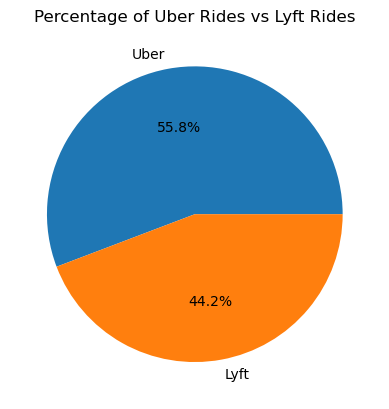

In [15]:
#Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()

percentages = (ride_counts / ride_counts.sum()) * 100

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.show()

In [16]:
#find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


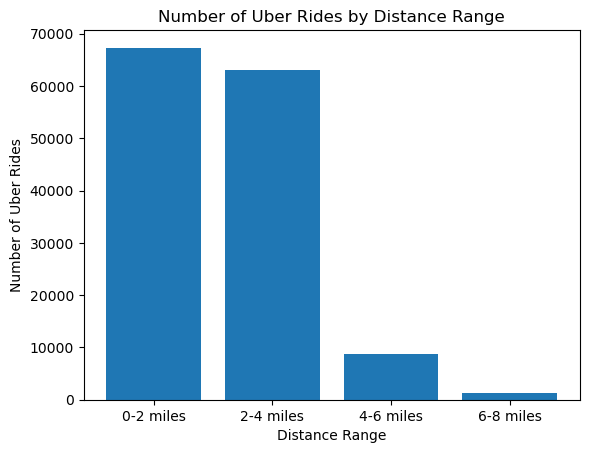

In [17]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Uber Rides")
plt.title("Number of Uber Rides by Distance Range")
plt.show()

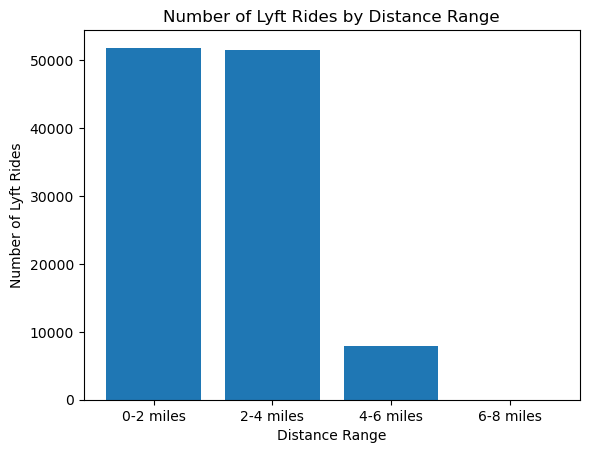

In [18]:
# Filter the DataFrame to include only Uber rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Lyft Rides")
plt.title("Number of Lyft Rides by Distance Range")
plt.show()

In [19]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()
revenue_df


Rideshare_App
Lyft    1930455.15
Uber    1902764.00
Name: Price($), dtype: float64

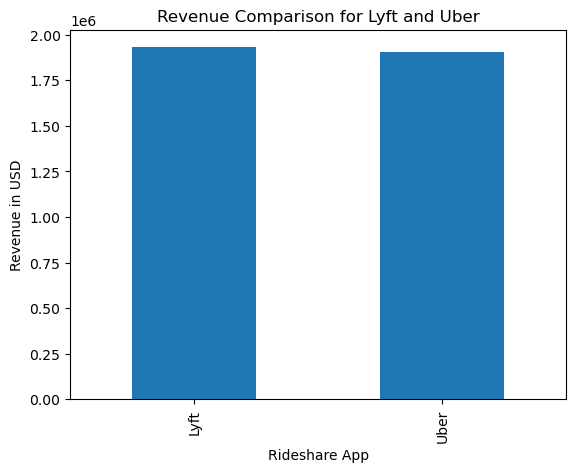

In [20]:
#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [21]:
#Monthly Revenue of each rideshare app
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("month")["Price($)"].sum()
lyft_monthly_rev

KeyError: 'month'

In [ ]:
uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["month"])["Price($)"].sum()
uber_monthly_rev

In [ ]:
#Created Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

In [ ]:
#Bar chart to show revenue based on months
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [ ]:
# higehst pay of each day for uber 
uber_ridecounts=final_df[final_df["Rideshare_App"]=="Uber"]
uber_highestday_price=uber_ridecounts.groupby(["Weekday"])["Price($)"].max()
uber_highestday_price

In [ ]:
# higehst pay of each day for lyft 
lyft_ridecounts=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_highestday_price=lyft_ridecounts.groupby(["Weekday"])["Price($)"].max()
lyft_highestday_price

In [ ]:
#created the line chart to show the comparison 
plt.figure(figsize=(16, 8), dpi=150)
uber_highestday_price.plot(color ="r", label ="uber highest price perday")
lyft_highestday_price.plot(color ="b", label ="lyft highest price perday")
plt.legend()

################################################################

################################################################

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean distance for each ride type
ride_types = final_df["Ride_Type"].unique()
mean_distances = final_df.groupby("Ride_Type")["Distance(m)"].mean()

# Convert ride_types to numerical values
ride_type_values = np.arange(len(ride_types))

# Plot the scatter plot
plt.scatter(mean_distances, ride_type_values)
plt.xlabel("Distance (m)")
plt.ylabel("Ride Type")
plt.title("Relationship between Distance and Ride Types - MEAN with Trend Line")

# Set the y-axis tick labels to be the car type labels
plt.yticks(ride_type_values, ride_types)

# Add a trend line
slope, intercept = np.polyfit(mean_distances, ride_type_values, 1)
trend_line = slope * mean_distances + intercept
plt.plot(mean_distances, trend_line, color='r')

plt.show()

# Print the list of ride types with their mean distances in descending order
ride_type_mean_distances = list(zip(ride_types, mean_distances))
sorted_ride_type_mean_distances = sorted(ride_type_mean_distances, key=lambda x: x[1], reverse=True)

print("RIDE TYPE: MEAN DISTANCE")
for ride_type, mean_distance in sorted_ride_type_mean_distances:
    print(f"{ride_type}: {mean_distance}")


Analysis to Above Plot: Relationship between Distance and Ride Types - MEAN with Trend Line

------------------------------------------------------
RIDE_TYPES based on Mean Distance Traveled (Ascending)

Lyft XL: 2.1982362362362364

Lux Black XL: 2.1912993788819874

Lux: 2.189124788536173

UberPool: 2.188624548200228

UberXL: 2.187021150318334

Shared: 2.186385775862069

Black SUV: 2.1855161548464537

AV: 2.18352231280841

Black: 2.181708813085118

Lyft: 2.1810269659292754

Lux Black: 2.1772834744276914

UberX: 2.1759399718279337

Taxi: 2.173469093440748

################################################################

################################################################

In [ ]:
import matplotlib.pyplot as plt

# Get unique ride types
ride_types1 = final_df['Ride_Type'].unique()

# Count rides for each ride type
ride_counts1 = final_df['Ride_Type'].value_counts()

# Sort the ride types based on the counts in descending order
sorted_ride_types = ride_counts1.sort_values(ascending=False).index

# Print the ride type and corresponding count in descending order
for ride_type in sorted_ride_types:
    count = ride_counts1[ride_type]
    print(f"RIDE_TYPE NAME ({ride_type}): {count}")

# Create the bar chart
plt.bar(sorted_ride_types, ride_counts1[sorted_ride_types])

# Set plot labels and title
plt.xlabel('Ride Type')
plt.ylabel('Counts')
plt.title('Ride Type Counts')

# Rotate x-axis tick labels for better readability (optional)
plt.xticks(rotation=90)

# Display the plot
plt.show()




In [ ]:
import matplotlib.pyplot as plt

# Get unique destination types
destination_types1 = final_df['Destination'].unique()

# Count rides for each destination type
destination_counts1 = final_df['Destination'].value_counts()

# Sort the destination types based on the counts in descending order
sorted_destination_types = destination_counts1.sort_values(ascending=False).index

# Print the destination type and corresponding count in descending order
for destination_type in sorted_destination_types:
    count = destination_counts1[destination_type]
    print(f"DESTINATION NAME ({destination_type}): {count}")

# Create the bar chart
plt.bar(sorted_destination_types, destination_counts1[sorted_destination_types])

# Set plot labels and title
plt.xlabel('Destination')
plt.ylabel('Counts')
plt.title('Destination Counts')

# Rotate x-axis tick labels for better readability (optional)
plt.xticks(rotation=90)

# Display the plot
plt.show()

# VARIABLE NAMES: destination_types1 // destination_counts1 //



In [ ]:
import matplotlib.pyplot as plt

# Get unique pick-up locations
pickup_locations1 = final_df['Pick_Up_Location'].unique()

# Count rides for each pick-up location
pickup_counts1 = final_df['Pick_Up_Location'].value_counts()

# Sort the pick-up locations based on the counts in descending order
sorted_pickup_locations = pickup_counts1.sort_values(ascending=False).index

# Print the pick-up location and corresponding count in descending order
for pickup_location in sorted_pickup_locations:
    count = pickup_counts1[pickup_location]
    print(f"PICK-UP LOCATION NAME ({pickup_location}): {count}")

# Create the bar chart with orange color
plt.bar(sorted_pickup_locations, pickup_counts[sorted_pickup_locations], color='orange')

# Set plot labels and title
plt.xlabel('Pick-up Location')
plt.ylabel('Counts')
plt.title('Pick-up Location Counts')

# Rotate x-axis tick labels for better readability (optional)
plt.xticks(rotation=90)

# Display the plot
plt.show()

# VARIABLES: pickup_locations1 // pickup_counts1



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given destination data
destinations4 = [
    'Financial District', 'Back Bay', 'Beacon Hill', 'Haymarket Square',
    'North Station', 'Boston University', 'Northeastern University', 'Theatre District',
    'West End', 'South Station', 'North End', 'Fenway'
]

destination_counts4 = [
    21842, 21148, 21142, 21095,
    20987, 20956, 20875, 20853,
    20801, 20721, 20712, 20695
]

# Given pick-up location data
pickup_locations4 = [
    'Haymarket Square', 'Northeastern University', 'South Station', 'North End',
    'Financial District', 'Fenway', 'Boston University', 'Theatre District',
    'West End', 'Beacon Hill', 'Back Bay', 'North Station'
]

pickup_counts4 = [
    21483, 21339, 21056, 21010,
    21002, 20971, 20914, 20884,
    20883, 20847, 20803, 20635
]

# Set the width of each bar
bar_width = 0.35

# Set the x positions of the bars
x = np.arange(len(destinations4))

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create the grouped bar chart
rects1 = ax.bar(x - bar_width/2, destination_counts4, bar_width, label='Destination', color='blue')
rects2 = ax.bar(x + bar_width/2, pickup_counts4, bar_width, label='Pick-up Location', color='orange')

# Set plot labels and title
ax.set_xlabel('Locations')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Destination and Pick-up Location Counts')
ax.set_xticks(x)
ax.set_xticklabels(destinations4, rotation=90)

# Print counts for both pick-up locations and destinations
print("Destination Counts:")
for destination, count in zip(destinations4, destination_counts4):
    print(f"DESTINATION NAME ({destination}): {count}")

print("\nPick-up Location Counts:")
for pickup_location, count in zip(pickup_locations4, pickup_counts4):
    print(f"PICK-UP LOCATION NAME ({pickup_location}): {count}")

# Customize legend properties and move it outside of the graph
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.1)  # Set legend transparency to 50%

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Top 3 destinations
top_destinations = ['Financial District', 'Back Bay', 'Beacon Hill']

# Get unique ride types
ride_types = final_df['Ride_Type'].unique()
ride_types.sort()

# Initialize counts dictionary for each destination and ride type
counts = {}
for destination in top_destinations:
    counts[destination] = {}
    for ride_type in ride_types:
        counts[destination][ride_type] = 0

# Count ride types for each destination
for index, row in final_df.iterrows():
    destination = row['Destination']
    ride_type = row['Ride_Type']
    if destination in top_destinations:
        counts[destination][ride_type] += 1

# Set colors for each destination
colors = {'Financial District': 'orange', 'Back Bay': 'blue', 'Beacon Hill': 'red'}

# Create the bar chart
x = np.arange(len(ride_types))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

for i, destination in enumerate(top_destinations):
    ride_type_counts = [counts[destination][ride_type] for ride_type in ride_types]
    ax.bar(x + i * width, ride_type_counts, width, label=destination, color=colors[destination])

# Set plot labels and title
ax.set_xlabel('Ride Type')
ax.set_ylabel('Counts')
ax.set_title('Ride Type Counts for Top 3 Destinations')
ax.set_xticks(x)
ax.set_xticklabels(ride_types, rotation=90)

# Add legend with 50% transparency
legend = ax.legend()
for lh in legend.legendHandles:
    lh.set_alpha(0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Top 3 destinations
top_destinations5 = ['Financial District', 'Back Bay', 'Beacon Hill']

# Get unique ride types
ride_types5 = final_df['Ride_Type'].unique()
ride_types5.sort()

# Initialize counts dictionary for each destination and ride type
counts5 = {}
for destination in top_destinations5:
    counts5[destination] = {}
    for ride_type in ride_types5:
        counts5[destination][ride_type] = 0

# Count ride types for each destination
for index, row in final_df.iterrows():
    destination = row['Destination']
    ride_type = row['Ride_Type']
    if destination in top_destinations5:
        counts5[destination][ride_type] += 1

# Set colors for each destination
colors5 = {'Financial District': 'orange', 'Back Bay': 'blue', 'Beacon Hill': 'red'}

# Create the bar chart
x = np.arange(len(ride_types5))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

for i, destination in enumerate(top_destinations5):
    ride_type_counts = [counts5[destination][ride_type] for ride_type in ride_types5]
    ax.bar(x + i * width, ride_type_counts, width, label=destination, color=colors5[destination])

# Set plot labels and title
ax.set_xlabel('Ride Type')
ax.set_ylabel('Counts')
ax.set_title('Ride Type Counts for Top 3 Destinations')
ax.set_xticks(x)
ax.set_xticklabels(ride_types5, rotation=90)

# Add legend with 50% transparency
legend = ax.legend()
for lh in legend.legendHandles:
    lh.set_alpha(0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Mean Values for Each Ride Type (Descending Order)
mean_values = {
    'UberX': 1712.0,
    'UberXL': 1712.0,
    'Black': 1703.6666666666667,
    'Taxi': 1700.3333333333333,
    'Black SUV': 1697.6666666666667,
    'UberPool': 1694.6666666666667,
    'WAV': 1694.6666666666667,
    'Lux Black XL': 1590.0,
    'Lyft XL': 1589.3333333333333,
    'Lyft': 1582.3333333333333,
    'Shared': 1571.0,
    'Lux': 1568.0,
    'Lux Black': 1561.6666666666667
}

# Extract ride types and mean values for plotting
ride_types = list(mean_values.keys())
mean_counts = list(mean_values.values())

# Sort the ride types and mean values in descending order
sorted_mean_values = {k: v for k, v in sorted(mean_values.items(), key=lambda item: item[1], reverse=True)}

# Print the ride types and their corresponding counts in descending order
print("Ride Type Counts (Descending Order):")
for ride_type, mean_count in sorted_mean_values.items():
    print(f"{ride_type}: {mean_count}")

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(ride_types, mean_counts)

# Set plot labels and title
ax.set_xlabel('Ride Type')
ax.set_ylabel('Mean Counts')
ax.set_title('Mean Values for Each Ride Type at Top Destinations (Financial District, Back Bay, Beacon Hill)')

# Rotate x-axis tick labels for better readability (90 degrees)
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()






In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Top 3 pick-up locations
top_locations6 = ['Haymarket Square', 'Northeastern University', 'South Station']

# Get unique ride types
ride_types6 = final_df['Ride_Type'].unique()
ride_types6.sort()

# Initialize counts dictionary for each location and ride type
counts6 = {}
for location in top_locations6:
    counts6[location] = {}
    for ride_type in ride_types6:
        counts6[location][ride_type] = 0

# Count ride types for each pick-up location
for index, row in final_df.iterrows():
    location = row['Pick_Up_Location']
    ride_type = row['Ride_Type']
    if location in top_locations6:
        counts6[location][ride_type] += 1

# Set colors for each location
colors6 = {'Haymarket Square': 'orange', 'Northeastern University': 'blue', 'South Station': 'red'}

# Create the bar chart
x = np.arange(len(ride_types6))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

for i, location in enumerate(top_locations6):
    ride_type_counts = [counts6[location][ride_type] for ride_type in ride_types6]
    ax.bar(x + i * width, ride_type_counts, width, label=location, color=colors6[location])

# Set plot labels and title
ax.set_xlabel('Ride Type')
ax.set_ylabel('Counts')
ax.set_title('Ride Type Counts for Top 3 Pick-up Locations')
ax.set_xticks(x)
ax.set_xticklabels(ride_types6, rotation=90)

# Add legend with 50% transparency
legend = ax.legend()
for lh in legend.legendHandles:
    lh.set_alpha(0.5)

# Display the plot
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Mean Values for Each Ride Type (Descending Order)
mean_values = {
    'Black': 1717.3333333333333,
    'UberXL': 1707.3333333333333,
    'UberPool': 1707.0,
    'Black SUV': 1700.3333333333333,
    'WAV': 1694.6666666666667,
    'UberX': 1691.0,
    'Taxi': 1687.6666666666667,
    'Lux': 1588.0,
    'Lyft': 1583.3333333333333,
    'Lux Black XL': 1566.6666666666667,
    'Lyft XL': 1555.0,
    'Lux Black': 1553.3333333333333,
    'Shared': 1541.0
}

# Sort the mean values in descending order
sorted_mean_values = {k: v for k, v in sorted(mean_values.items(), key=lambda item: item[1], reverse=True)}

# Extract ride types and mean values for plotting
ride_types = list(sorted_mean_values.keys())
mean_counts = list(sorted_mean_values.values())

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(ride_types, mean_counts)

# Set plot labels and title
ax.set_xlabel('Ride Type')
ax.set_ylabel('Counts')
ax.set_title('Mean Values for Each Ride Type (Descending Order)')

# Rotate x-axis tick labels for better readability (90 degrees)
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

# Print the ride type and their corresponding counts in descending order
print("Mean Values for Each Ride Type (Descending Order):")
for ride_type, mean_count in sorted_mean_values.items():
    print(f"{ride_type}: {mean_count}")

In [ ]:
##############################################################################33

In [ ]:
#MIKE - NORMAL TEST HISTOGRAM for RIDE_TYPE-to-PRICE$ relationship, look for BELL CURVE

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Perform normality test and create histograms for each ride type
for car_type in unique_car_types:
    # Filter dataframe for the current ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Perform normality test on price column
    _, p_value = stats.normaltest(filtered_df['Price($)'])
    
    # Set a smaller figure size (25% smaller)
    fig, ax = plt.subplots(figsize=(4, 2))
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{car_type} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()



Analysis to Above Plot: RIDE_TYPE-to-PRICE($) NORMAL TEST HISTOGRAMS

------------------------------------------------------

As no RIDE_TYPE-to-PRICE NORMAL TEST HISTOGRAM above displays a traditional BELL CURVE, we may infer that the RIDE_TYPE-to-PRICE DATA is not Normally Distributed. 

##########################################################

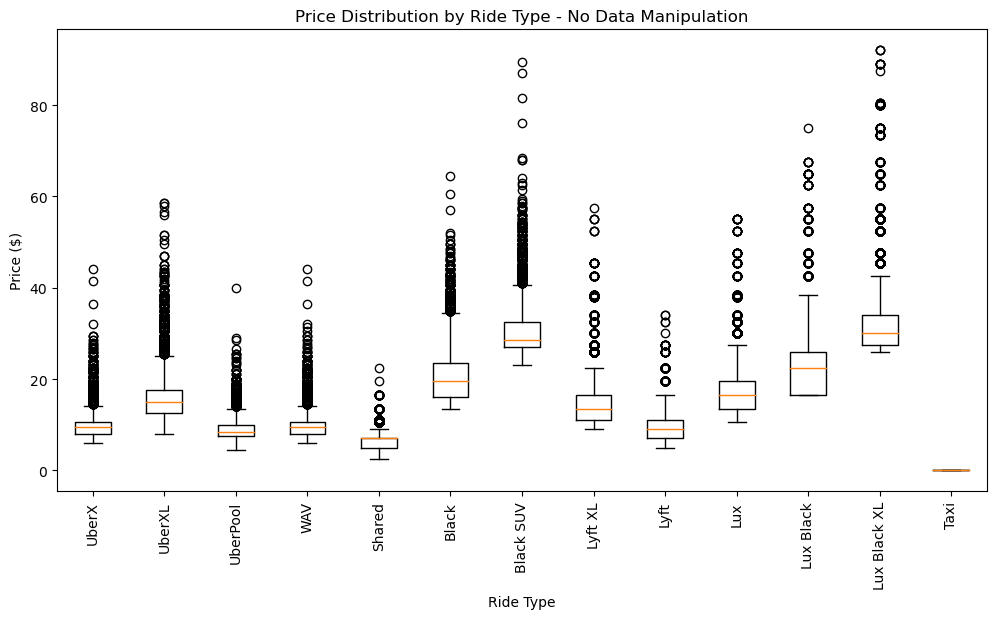

In [22]:
# Price Distribution by Car Type, BOX & WHISKER
# Step 1: Reference each unique car type
unique_car_types = [ 'UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect prices for each unique car type
car_type_prices = []
for car_type in unique_car_types:
    prices = final_df.loc[final_df['Ride_Type'] == car_type, 'Price($)']
    car_type_prices.append(prices)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_prices, labels=unique_car_types)
plt.title('Price Distribution by Ride Type - No Data Manipulation')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

Analysis to Above Plot: RIDE_TYPE-to-PRICE($) NORMAL TEST HISTOGRAMS

------------------------------------------------------
Plotting 
-'BOX PLOTS - Price Distribution by Car Type' 
...appears to confirm what we saw in the: 
-RIDE_TYPE-to-PRICENORMAL TEST HISTOGRAMS 
...that there are many OUTLIERS in our original RIDE_TYPE-to-PRICE DATA.

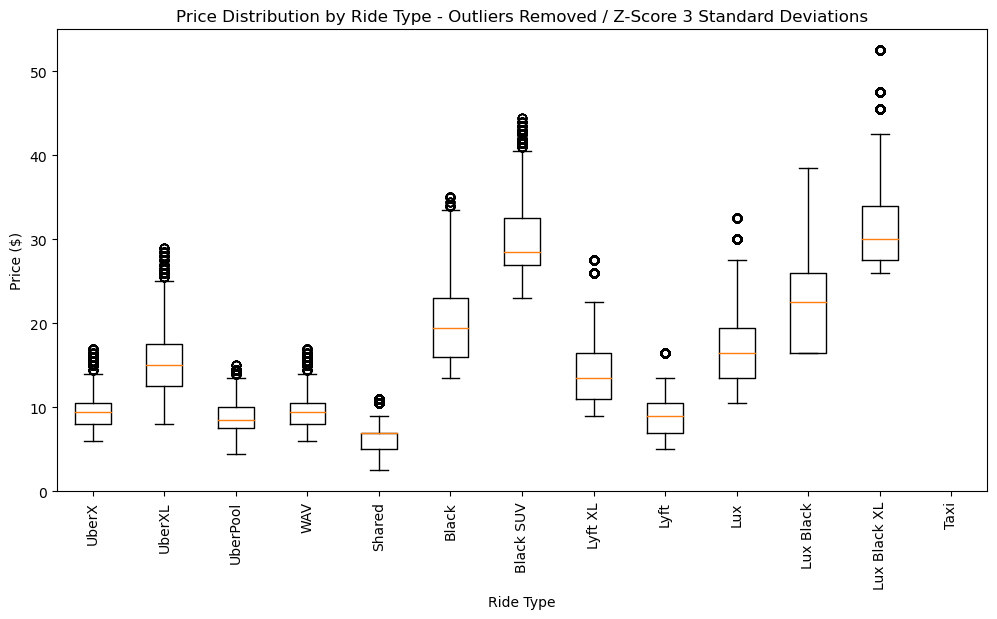

Median price for Lux Black XL: 30.0
Median price for Black SUV: 28.5
Median price for Lux Black: 22.5
Median price for Black: 19.5
Median price for Lux: 16.5
Median price for UberXL: 15.0
Median price for Lyft XL: 13.5
Median price for UberX: 9.5
Median price for WAV: 9.5
Median price for Lyft: 9.0
Median price for UberPool: 8.5
Median price for Shared: 7.0
Median price for Taxi: nan


/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
# Price Distribution by Car Type, BOX & WHISKER / Z-SCORE, Outliers removed

# 1. Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2. Collect prices for each unique car type
car_type_prices = []
for car_type in unique_car_types:
    prices = final_df.loc[final_df['Ride_Type'] == car_type, 'Price($)']

    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    car_type_prices.append(filtered_prices)

# 3. Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_prices, labels=unique_car_types)
plt.title('Price Distribution by Ride Type - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# Calculate and print the sorted median prices
median_prices = {car_type: np.median(prices) for car_type, prices in zip(unique_car_types, car_type_prices)}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for car_type, median_price in sorted_median_prices:
    print(f"Median price for {car_type}: {median_price}")


Analysis to Above Plot: 'Price Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------
Top Values in Central Tendency - Price to Ride_Type:

Median price for Lux Black XL: 30.0

Median price for Black SUV: 28.5

Median price for Lux Black: 22.5

Median price for Black: 19.5

Median price for Lux: 16.5

Median price for UberXL: 15.0

Median price for Lyft XL: 13.5

Median price for UberX: 9.5

Median price for WAV: 9.5

Median price for Lyft: 9.0

Median price for UberPool: 8.5

Median price for Shared: 7.0

Median price for Taxi: nan


################################################################

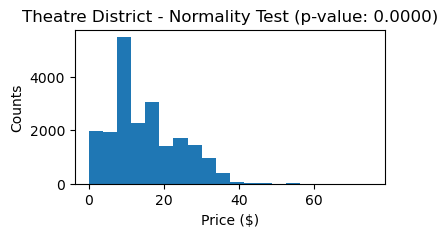

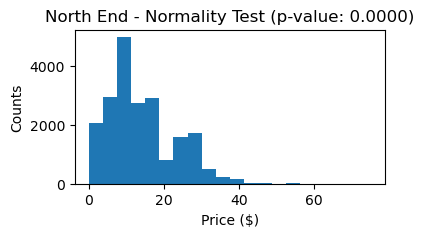

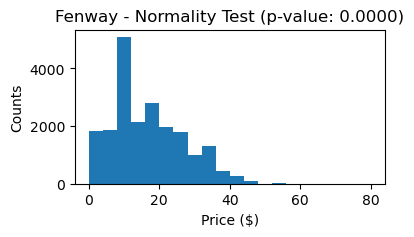

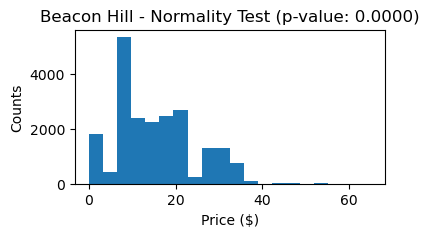

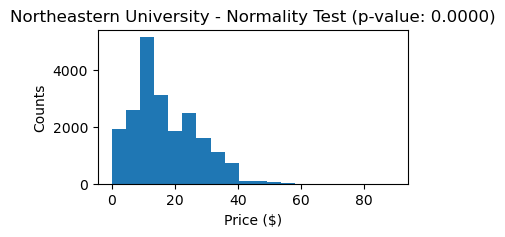

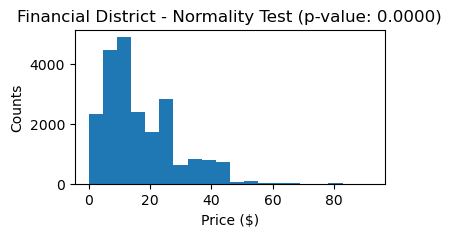

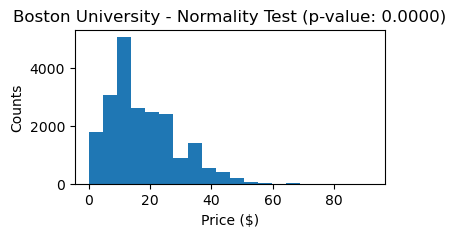

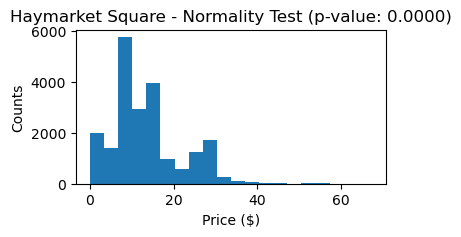

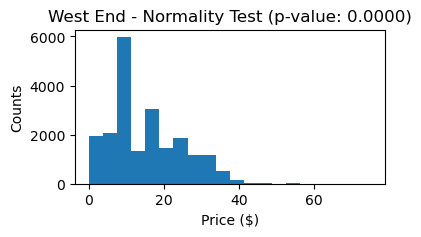

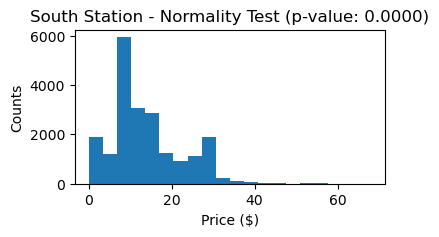

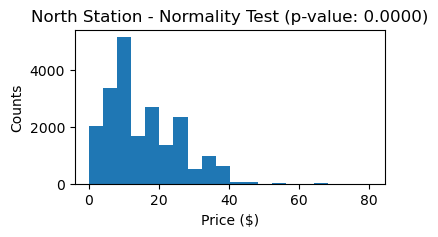

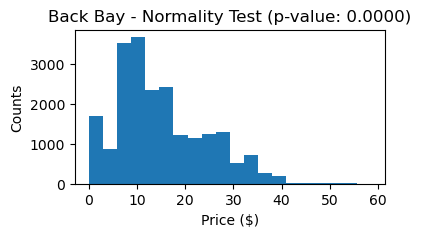

In [24]:
# NORMALTEST HISTOGRAMS for DESTINATION-to-PRICE relationship, look for BELL CURVE

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unique destinations
unique_destinations = final_df['Destination'].unique()

# Perform normality test and create histograms for each destination
for destination in unique_destinations:
    # Filter dataframe for the current destination
    filtered_df = final_df[final_df['Destination'] == destination]
    
    # Perform normality test on price column
    _, p_value = stats.normaltest(filtered_df['Price($)'])
    
     # Set a smaller figure size (25% smaller)
    fig, ax = plt.subplots(figsize=(4, 2))
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{destination} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()


Analysis to Above Plot: DESTINATION-to-PRICE($) NORMALTEST HISTOGRAMS

------------------------------------------------------

As no DESTINATION-to-PRICE NORMAL TEST HISTOGRAM above displays a traditional BELL CURVE, we may infer that the DESTINATION-to-PRICE DATA is not Normally Distributed.

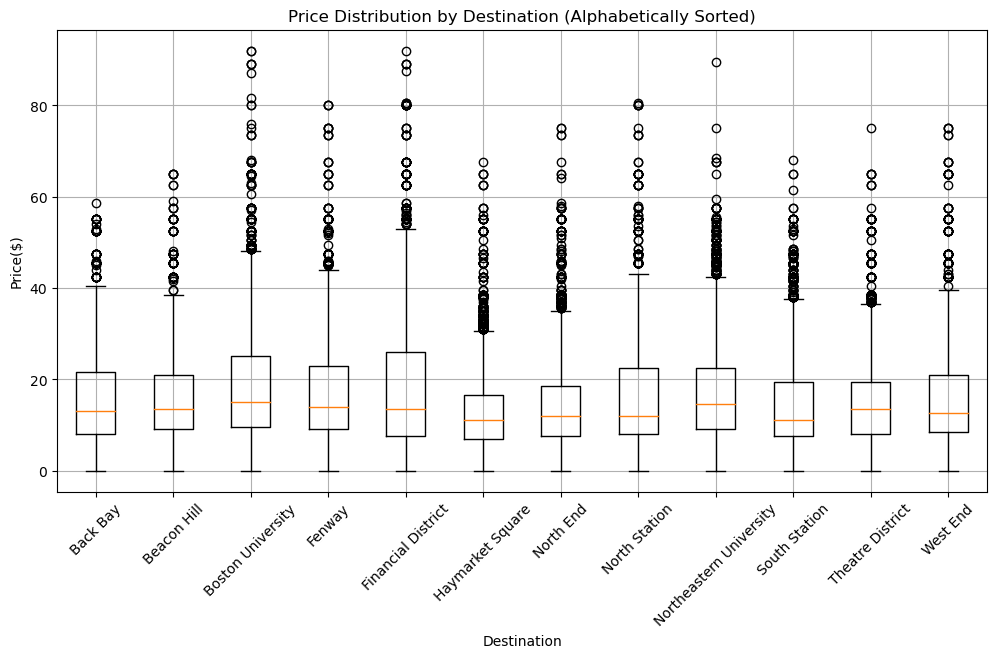

In [25]:
# Price Distribution by Destination (Alphabetically Sorted)

# Extract destination locations and sort alphabetically
destinations = sorted(final_df["Destination"].unique())

# Create a dictionary to store destination prices
destination_prices = {}

# Iterate over each destination
for destination in destinations:
    # Filter rows for the current destination
    destination_data = final_df[final_df["Destination"] == destination]
    # Get the prices for the current destination
    prices = destination_data["Price($)"].values
    # Store the prices in the dictionary
    destination_prices[destination] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(destination_prices.values())
plt.xticks(range(1, len(destinations) + 1), destinations, rotation=45)
plt.xlabel("Destination")
plt.ylabel("Price($)")
plt.title("Price Distribution by Destination (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()


Analysis to Above Plot: DESTINATION-to-PRICE($) NORMAL TEST HISTOGRAMS

------------------------------------------------------
Plotting 
-'BOX PLOTS - Price Distribution by Destination - Alphabetically Sorted' 
...appears to confirm what we saw in the: 
-DESTINATION-to-PRICE NORMALTEST HISTOGRAMS 
...that there are many OUTLIERS in our original DESTINATION-to-PRICE DATA.

#######################################################

Median price for Boston University: 15.0
Median price for Northeastern University: 14.0
Median price for Beacon Hill: 13.5
Median price for Fenway: 13.5
Median price for Financial District: 13.5
Median price for Theatre District: 13.5
Median price for Back Bay: 13.0
Median price for West End: 12.5
Median price for North Station: 12.0
Median price for North End: 11.5
Median price for Haymarket Square: 11.0
Median price for South Station: 11.0


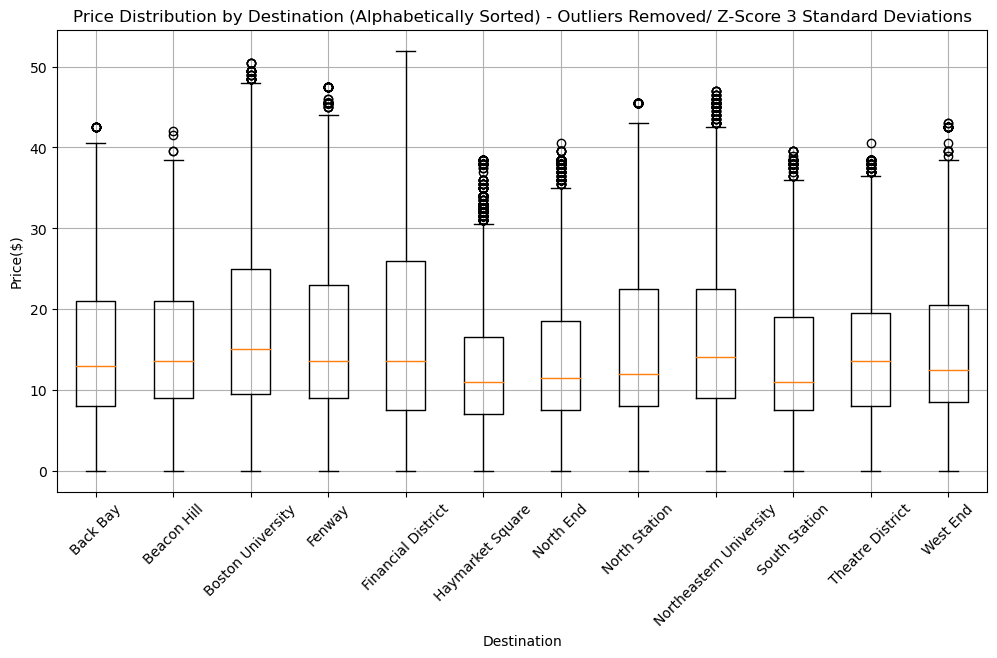

In [26]:

# Price Distribution by Destination (Alphabetically Sorted) - Z-SCORE, Outliers removed

# Extract destination locations and sort alphabetically
destinations = sorted(final_df["Destination"].unique())

# Create a dictionary to store destination prices
destination_prices = {}

# Iterate over each destination
for destination in destinations:
    # Filter rows for the current destination
    destination_data = final_df[final_df["Destination"] == destination]
    # Get the prices for the current destination
    prices = destination_data["Price($)"].values
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered prices in the dictionary
    destination_prices[destination] = filtered_prices

# Calculate and sort the median prices in descending order
median_prices = {destination: np.median(prices) for destination, prices in destination_prices.items()}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for destination, median_price in sorted_median_prices:
    print(f"Median price for {destination}: {median_price}")

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(destination_prices.values())
plt.xticks(range(1, len(destinations) + 1), destinations, rotation=45)
plt.xlabel("Destination")
plt.ylabel("Price($)")
plt.title("Price Distribution by Destination (Alphabetically Sorted) - Outliers Removed/ Z-Score 3 Standard Deviations")
plt.grid(True)

# Display the plot
plt.show()


Analysis to Above Plot: 'Price Distribution by Destination - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------

Values in Central Tendency - Destination:

Median price for Boston University: 15.0

Median price for Northeastern University: 14.0

Median price for Beacon Hill: 13.5

Median price for Fenway: 13.5

Median price for Financial District: 13.5

Median price for Theatre District: 13.5

Median price for Back Bay: 13.0

Median price for West End: 12.5

Median price for North Station: 12.0

Median price for North End: 11.5

Median price for Haymarket Square: 11.0

Median price for South Station: 11.0


################################################################

################################################################

/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


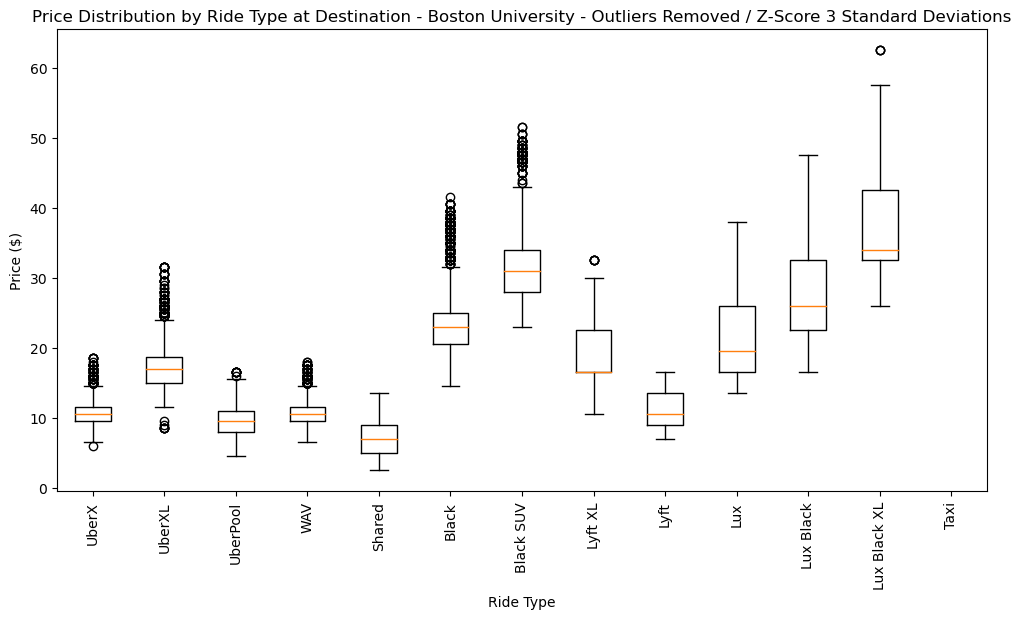

Median Prices:
Median price for UberX: 10.50
Median price for UberXL: 17.00
Median price for UberPool: 9.50
Median price for WAV: 10.50
Median price for Shared: 7.00
Median price for Black: 23.00
Median price for Black SUV: 31.00
Median price for Lyft XL: 16.50
Median price for Lyft: 10.50
Median price for Lux: 19.50
Median price for Lux Black: 26.00
Median price for Lux Black XL: 34.00
Median price for Taxi: nan


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Price Distribution by Ride Type at Boston University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Boston University destination and collect prices for each unique ride type
ride_type_prices = []
median_prices = {}  # Dictionary to store median prices for each ride type

for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Destination'] == 'Boston University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Calculate the median price for the current ride type
    median_price = np.median(filtered_prices)
    median_prices[ride_type] = median_price

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Boston University
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type at Destination - Boston University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# 4 Print out median prices for each ride type
print("Median Prices:")
for ride_type, median_price in median_prices.items():
    print(f"Median price for {ride_type}: {median_price:.2f}")


Analysis to Above Plot: 'Price Distribution by Ride Type at Boston University - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------
Since our Top Value in Central Tendency - PRICE to DESTINATION are as follows...let's see the most common RIDE_TYPEs at this Top Locations:
1-Boston University

--------------------------------------------------------------
Top RIDE_TYPE Values in Central Tendency - Destination - Boston University:
1-Lux Black XL
2-Lux Black
3-Black SUV
4-Black

/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


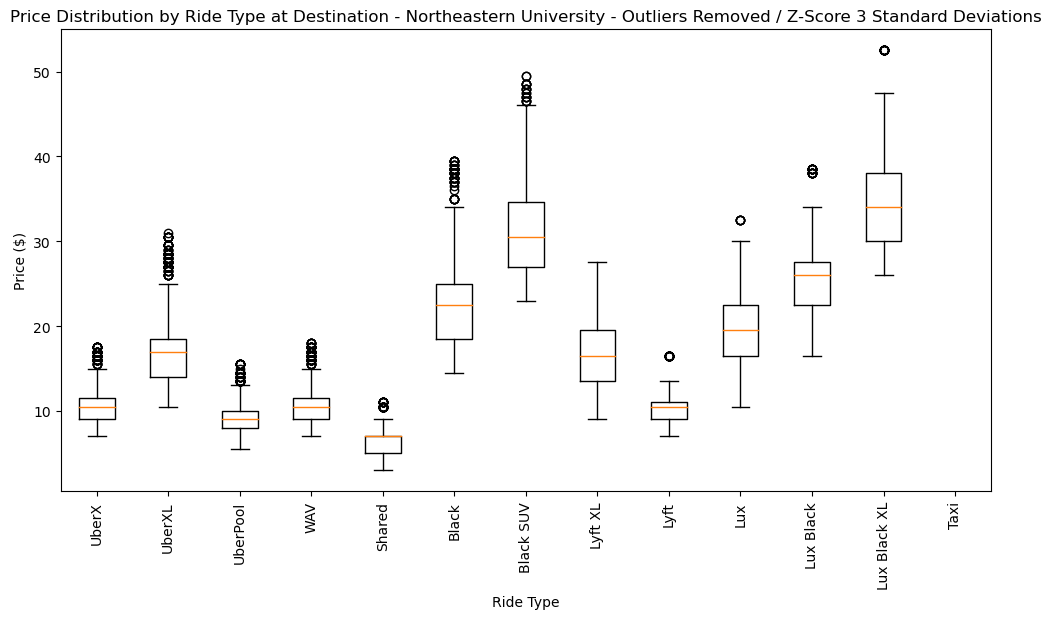

Median Prices:
Median price for UberX: 10.50
Median price for UberXL: 17.00
Median price for UberPool: 9.00
Median price for WAV: 10.50
Median price for Shared: 7.00
Median price for Black: 22.50
Median price for Black SUV: 30.50
Median price for Lyft XL: 16.50
Median price for Lyft: 10.50
Median price for Lux: 19.50
Median price for Lux Black: 26.00
Median price for Lux Black XL: 34.00
Median price for Taxi: nan


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Price Distribution by Ride Type at Northeastern University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Northeastern University destination and collect prices for each unique ride type
ride_type_prices = []
median_prices = {}  # Dictionary to store median prices for each ride type

for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Destination'] == 'Northeastern University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Calculate the median price for the current ride type
    median_price = np.median(filtered_prices)
    median_prices[ride_type] = median_price

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Northeastern University
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type at Destination - Northeastern University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# 4 Print out median prices for each ride type
print("Median Prices:")
for ride_type, median_price in median_prices.items():
    print(f"Median price for {ride_type}: {median_price:.2f}")


Analysis to Above Plot: 'Price Distribution by Ride Type at Northeastern - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------
Since our Top 2 Values in Central Tendency - PRICE to DESTINATION are as follows...let's see the most common RIDE_TYPEs at those Top 2 Locations:
1-Boston University
2-Northeastern University

--------------------------------------------------------------
Top Values in Central Tendency - PRICE to DESTINATION - Northeastern University:
Median Prices:
1-Median price for Lux Black XL: 34.00
2-Median price for Black SUV: 30.50
3-Median price for Lux Black: 26.00
4-Median price for Black: 22.50
5-Median price for Lux: 19.50
6-Median price for UberXL: 17.00
7-Median price for Lyft XL: 16.50
8-Median price for UberX: 10.50
9-Median price for WAV: 10.50
10-Median price for Lyft: 10.50
11-Median price for UberPool: 9.00
12-Median price for Shared: 7.00
13-Median price for Taxi: nan


##################################################################

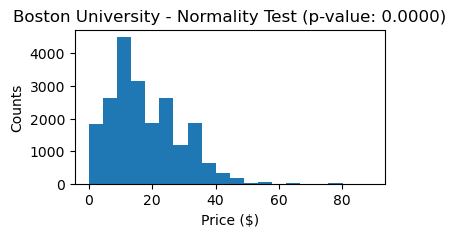

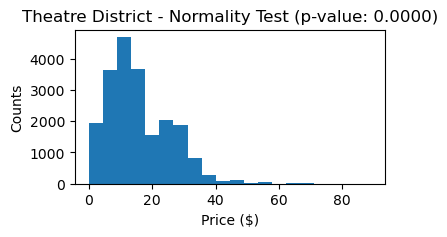

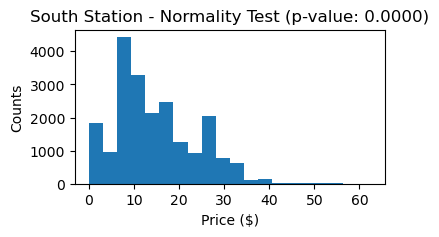

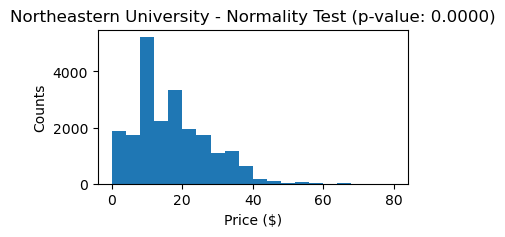

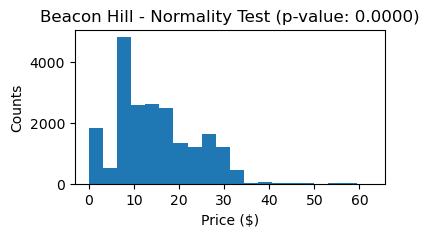

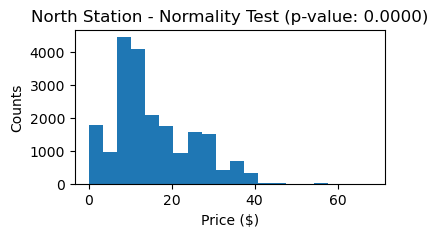

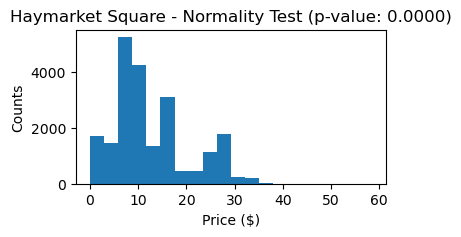

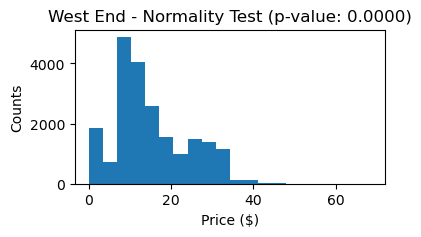

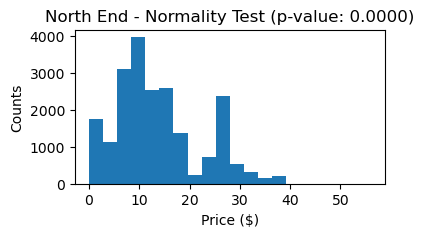

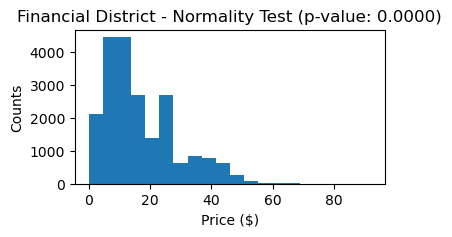

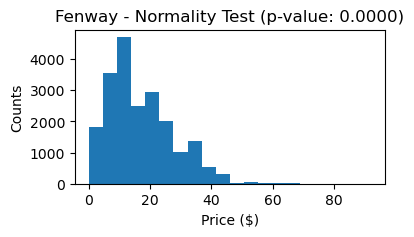

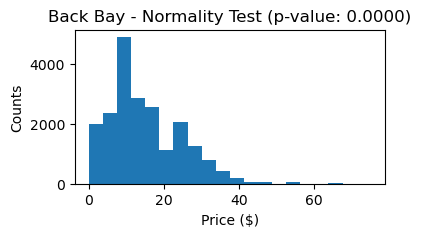

In [29]:
# NORMALTEST HISTOGRAMS for PICK_UP_LOCATION-to-PRICE relationship, look for BELL CURVE

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unique pick-up locations
unique_pickup_locations = final_df['Pick_Up_Location'].unique()

# Perform normality test and create histograms for each pick-up location
for pickup_location in unique_pickup_locations:
    # Filter dataframe for the current pick-up location
    filtered_df = final_df[final_df['Pick_Up_Location'] == pickup_location]
    
    # Perform normality test on price column
    _, p_value = stats.normaltest(filtered_df['Price($)'])
    
     # Set a smaller figure size (25% smaller)
    fig, ax = plt.subplots(figsize=(4, 2))
    
    # Create histogram
    plt.hist(filtered_df['Price($)'], bins=20)
    plt.title(f'{pickup_location} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Price ($)')
    plt.ylabel('Counts')
    plt.show()


Analysis to Above Plot: PICK_UP_LOCATION-to-PRICE($) NORMALTEST HISTOGRAMS

------------------------------------------------------

As no PICK_UP_LOCATION-to-PRICE NORMAL TEST HISTOGRAM above displays a traditional BELL CURVE, we may infer that the PICK_UP_LOCATION-to-PRICE($) DATA is not Normally Distributed.

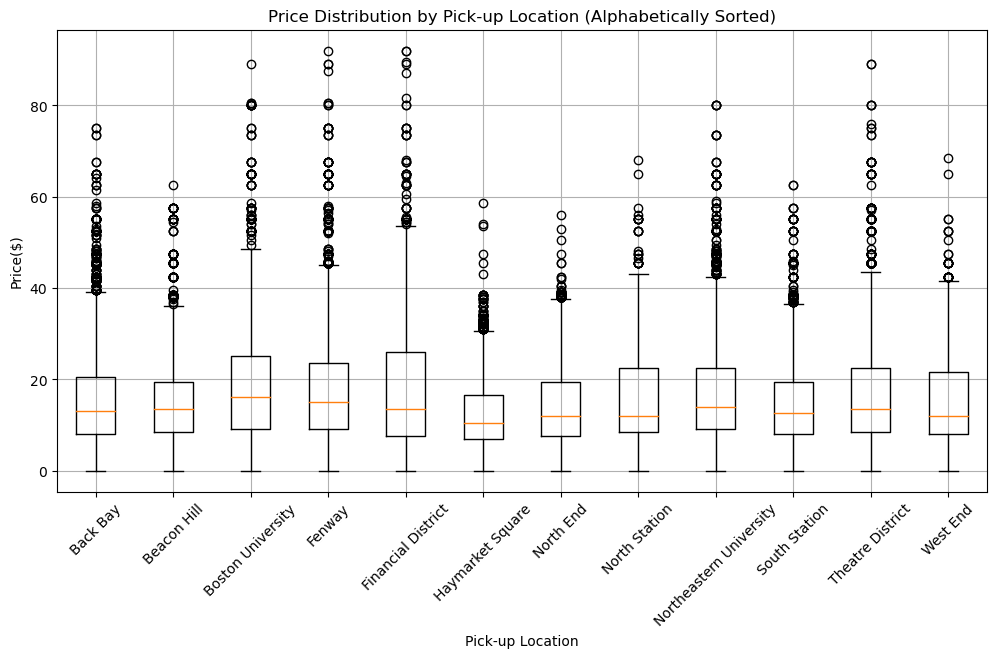

In [30]:
# Price Distribution by Pick-up Location (Alphabetically Sorted)
# Extract pick-up locations and sort alphabetically
pickup_locations = sorted(final_df["Pick_Up_Location"].unique())

# Create a dictionary to store pick-up location prices
pickup_prices = {}

# Iterate over each pick-up location
for pickup_location in pickup_locations:
    # Filter rows for the current pick-up location
    pickup_data = final_df[final_df["Pick_Up_Location"] == pickup_location]
    # Get the prices for the current pick-up location
    prices = pickup_data["Price($)"].values
    # Store the prices in the dictionary
    pickup_prices[pickup_location] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(pickup_prices.values())
plt.xticks(range(1, len(pickup_locations) + 1), pickup_locations, rotation=45)
plt.xlabel("Pick-up Location")
plt.ylabel("Price($)")
plt.title("Price Distribution by Pick-up Location (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()

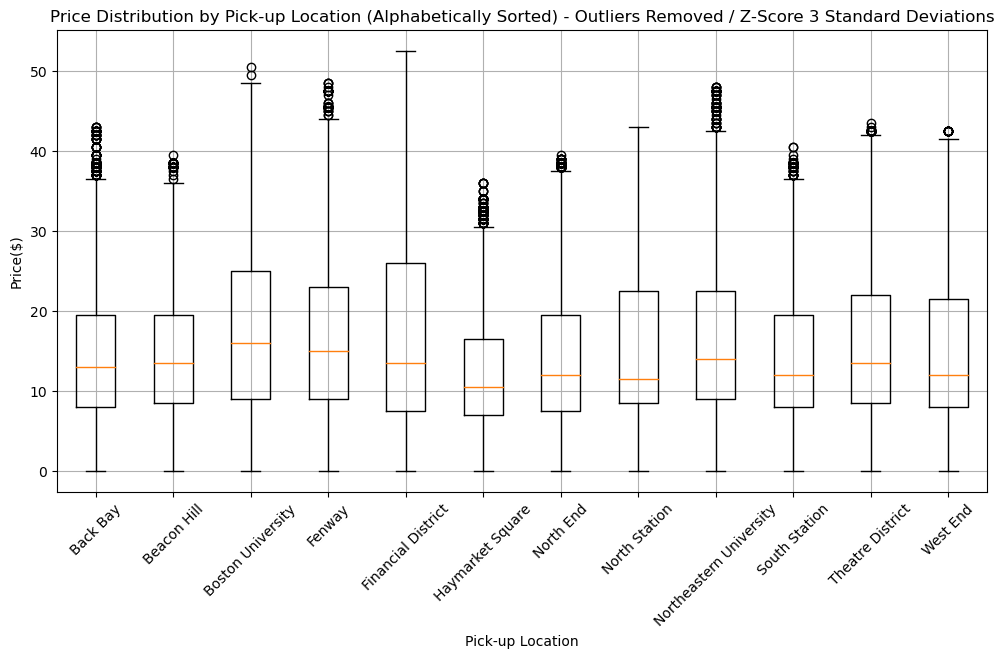

Median price for Boston University: 16.0
Median price for Fenway: 15.0
Median price for Northeastern University: 14.0
Median price for Beacon Hill: 13.5
Median price for Financial District: 13.5
Median price for Theatre District: 13.5
Median price for Back Bay: 13.0
Median price for North End: 12.0
Median price for South Station: 12.0
Median price for West End: 12.0
Median price for North Station: 11.5
Median price for Haymarket Square: 10.5


In [31]:
# Price Distribution by PICK_UP_LOCATION (Alphabetically Sorted) - Z-SCORE, Outliers removed

# Extract pick-up locations and sort alphabetically
pickup_locations = sorted(final_df["Pick_Up_Location"].unique())

# Create a dictionary to store pick-up location prices
pickup_prices = {}

# Iterate over each pick-up location
for pickup_location in pickup_locations:
    # Filter rows for the current pick-up location
    pickup_data = final_df[final_df["Pick_Up_Location"] == pickup_location]
    # Get the prices for the current pick-up location
    prices = pickup_data["Price($)"].values
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered prices in the dictionary
    pickup_prices[pickup_location] = filtered_prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(pickup_prices.values())
plt.xticks(range(1, len(pickup_locations) + 1), pickup_locations, rotation=45)
plt.xlabel("Pick-up Location")
plt.ylabel("Price($)")
plt.title("Price Distribution by Pick-up Location (Alphabetically Sorted) - Outliers Removed / Z-Score 3 Standard Deviations")
plt.grid(True)

# Display the plot
plt.show()

# Calculate and print the sorted median prices
median_prices = {pickup_location: np.median(prices) for pickup_location, prices in pickup_prices.items()}
sorted_median_prices = sorted(median_prices.items(), key=lambda x: x[1], reverse=True)

# Print the sorted median prices
for pickup_location, median_price in sorted_median_prices:
    print(f"Median price for {pickup_location}: {median_price}")


ANALYSIS TO ABOVE PLOT: 'PRICE DISTRIBUTION BY PICK_UP_LOCATION - OUTLIERS REMOVED / Z-SCORE 3 STANDARD DEVIATIONS'

--------------------------------------------------------------
Top Values in Central Tendency - Pick_Up_Location:

Median price for Boston University: 16.0

Median price for Fenway: 15.0

Median price for Northeastern University: 14.0

Median price for Beacon Hill: 13.5

Median price for Financial District: 13.5

Median price for Theatre District: 13.5

Median price for Back Bay: 13.0

Median price for North End: 12.0

Median price for South Station: 12.0

Median price for West End: 12.0

Median price for North Station: 11.5

Median price for Haymarket Square: 10.5


############################################################

/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


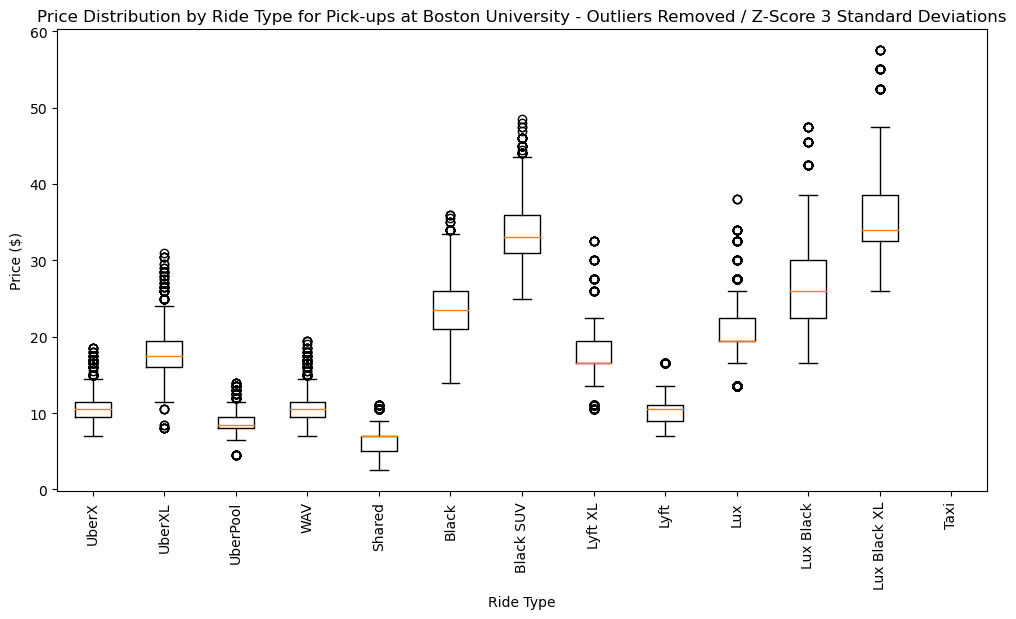

Median Prices:
Median price for UberX: 10.50
Median price for UberXL: 17.50
Median price for UberPool: 8.50
Median price for WAV: 10.50
Median price for Shared: 7.00
Median price for Black: 23.50
Median price for Black SUV: 33.00
Median price for Lyft XL: 16.50
Median price for Lyft: 10.50
Median price for Lux: 19.50
Median price for Lux Black: 26.00
Median price for Lux Black XL: 34.00
Median price for Taxi: nan


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Price Distribution by Ride Type for Pick-ups at Boston University, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Boston University pick-up location and collect prices for each unique ride type
ride_type_prices = []
median_prices = {}  # Dictionary to store median prices for each ride type

for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Pick_Up_Location'] == 'Boston University') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Calculate the median price for the current ride type
    median_price = np.median(filtered_prices)
    median_prices[ride_type] = median_price

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Boston University as the pick-up location
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type for Pick-ups at Boston University - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# 4 Print out median prices for each ride type
print("Median Prices:")
for ride_type, median_price in median_prices.items():
    print(f"Median price for {ride_type}: {median_price:.2f}")


Analysis to Above Plot: 'Price Distribution by Ride Type - Pickup - at Boston U - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------
Since our Top 2 Values in Central Tendency - PRICE TO PICK_UP_LOCATIONS are as follows...let's see the most common RIDE_TYPEs at those Top 2 Locations:
1-Boston University
2-Fenway

--------------------------------------------------------------
Top Values in Central Tendency - Boston U:
1-Median price for Lux Black XL: 34.00
2-Median price for Black SUV: 33.00
3-Median price for Lux Black: 26.00
4-Median price for Black: 23.50
5-Median price for UberXL: 17.50
6-Median price for Lyft XL: 16.50
7-Median price for Lux: 19.50
8-Median price for UberX: 10.50
9-Median price for WAV: 10.50
10-Median price for Lyft: 10.50
11-Median price for UberPool: 8.50
12-Median price for Shared: 7.00
13-Median price for Taxi: nan

/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michaelstrati/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


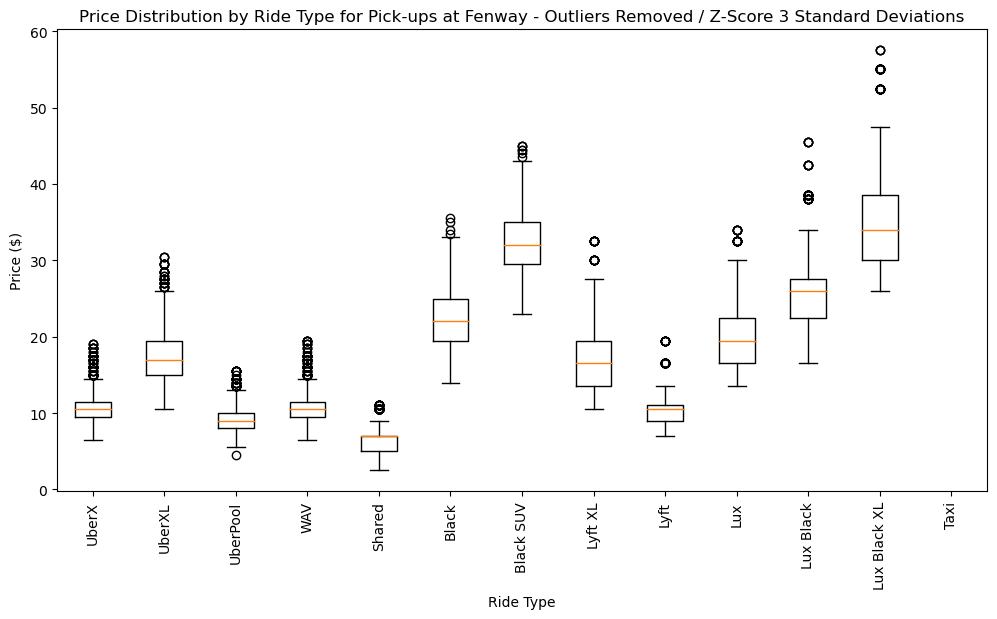

Median Prices:
Median price for UberX: 10.50
Median price for UberXL: 17.00
Median price for UberPool: 9.00
Median price for WAV: 10.50
Median price for Shared: 7.00
Median price for Black: 22.00
Median price for Black SUV: 32.00
Median price for Lyft XL: 16.50
Median price for Lyft: 10.50
Median price for Lux: 19.50
Median price for Lux Black: 26.00
Median price for Lux Black XL: 34.00
Median price for Taxi: nan


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Price Distribution by Ride Type for Pick-ups at Fenway, BOX & WHISKER / Z-SCORE, Outliers removed

# 1 Reference each unique ride type
unique_ride_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2 Filter dataframe for Fenway pick-up location and collect prices for each unique ride type
ride_type_prices = []
median_prices = {}  # Dictionary to store median prices for each ride type

for ride_type in unique_ride_types:
    prices = final_df.loc[(final_df['Pick_Up_Location'] == 'Fenway') & (final_df['Ride_Type'] == ride_type), 'Price($)']
    
    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Calculate the median price for the current ride type
    median_price = np.median(filtered_prices)
    median_prices[ride_type] = median_price

    ride_type_prices.append(filtered_prices)

# 3 Create box-and-whisker plot for all unique ride types at Fenway as the pick-up location
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(ride_type_prices, labels=unique_ride_types)
plt.title('Price Distribution by Ride Type for Pick-ups at Fenway - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Ride Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

# 4 Print out median prices for each ride type
print("Median Prices:")
for ride_type, median_price in median_prices.items():
    print(f"Median price for {ride_type}: {median_price:.2f}")


Analysis to Above Plot: 'Price Distribution by Ride Type at Fenway - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------
Since our Top 2 Values in Central Tendency - PRICE TO PICK_UP_LOCATIONS are as follows...let's see the most common RIDE_TYPEs at those Top 2 Locations:
1-Boston University
2-Fenway

--------------------------------------------------------------
Top Values in Central Tendency - Fenway:
1-Median price for Lux Black XL: 34.00
2-Median price for Black SUV: 32.00
3-Median price for Lux Black: 26.00
4-Median price for Black: 22.00
5-Median price for UberXL: 17.00
6-Median price for Lyft XL: 16.50
7-Median price for Lux: 19.50
8-Median price for UberX: 10.50
9-Median price for WAV: 10.50
10-Median price for Lyft: 10.50
11-Median price for UberPool: 9.00
12-Median price for Shared: 7.00
13-Median price for Taxi: nan


######################################################################

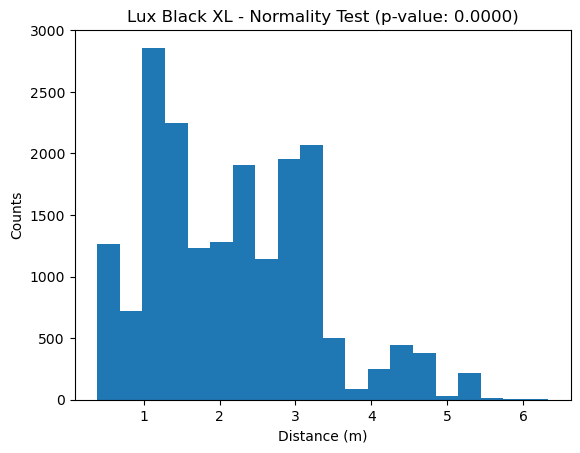

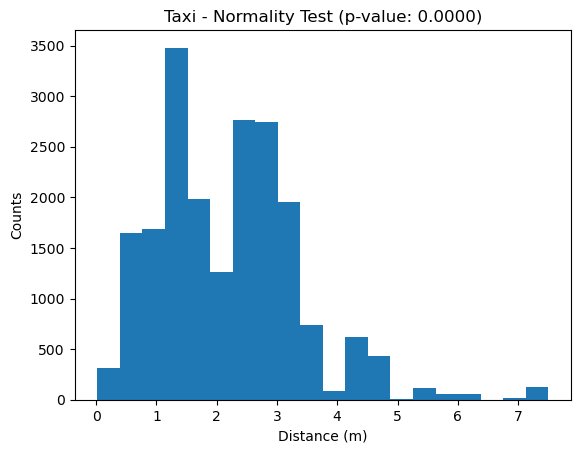

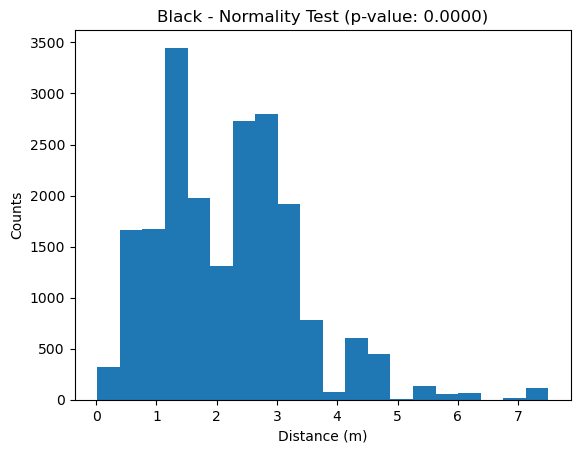

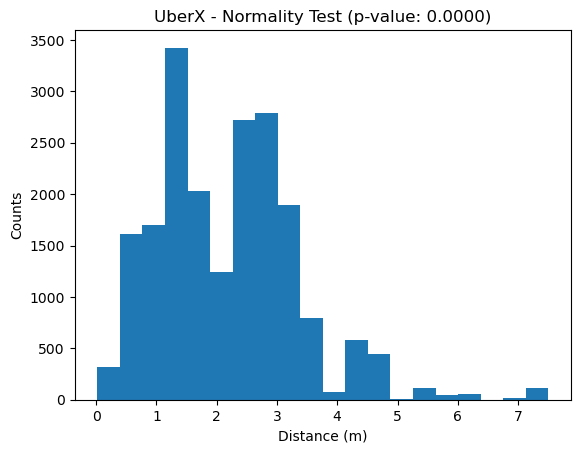

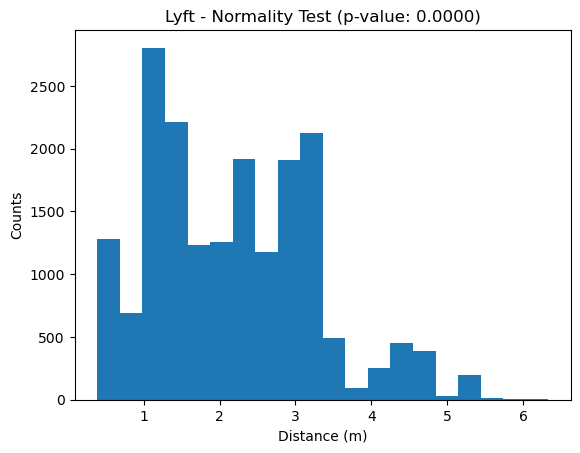

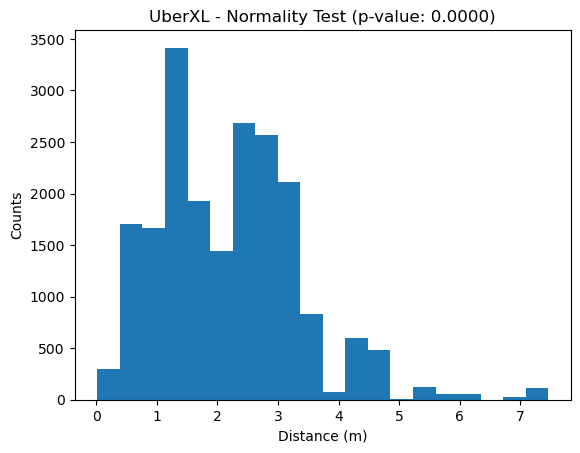

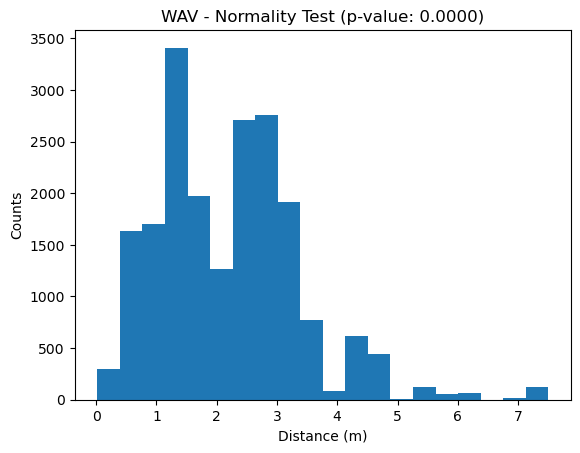

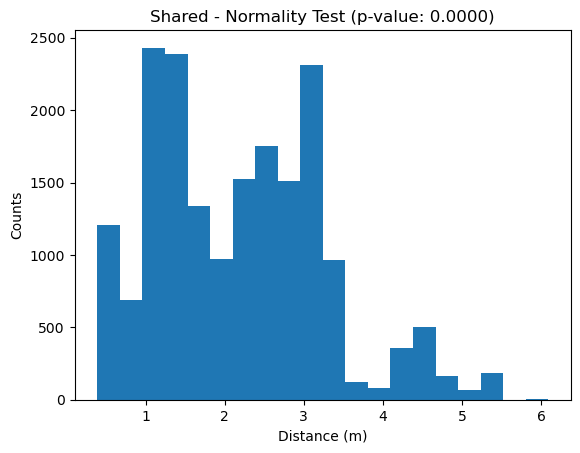

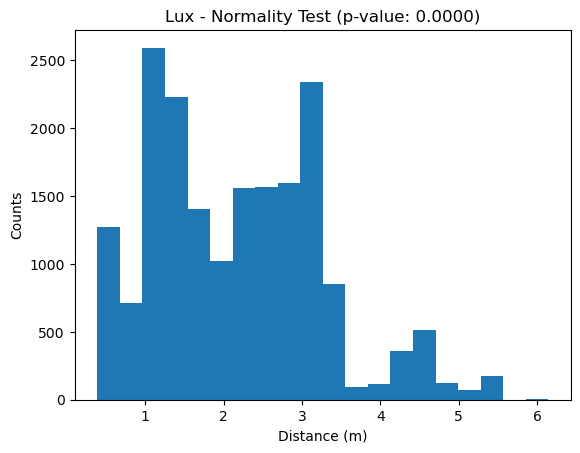

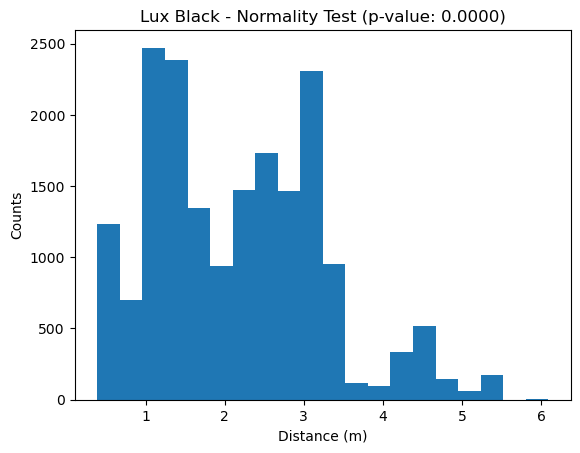

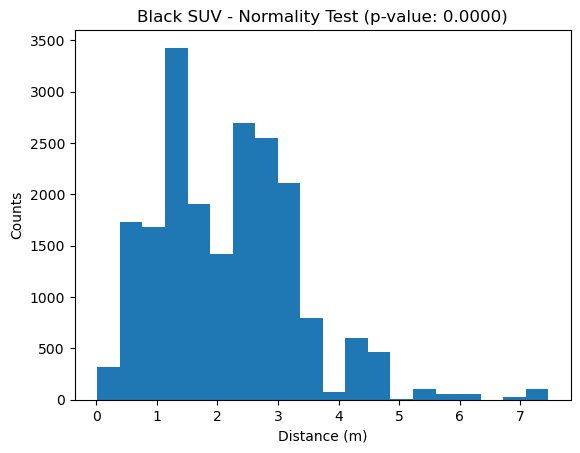

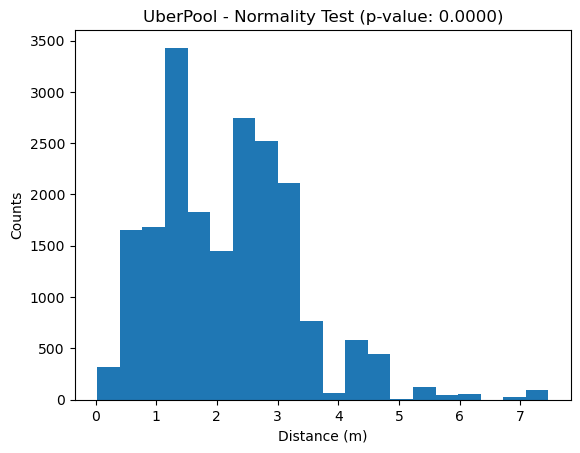

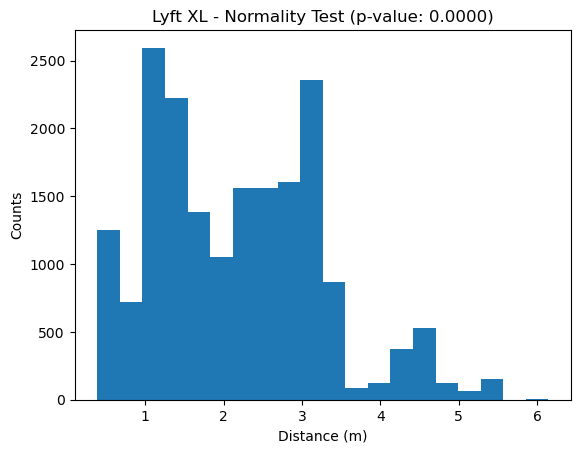

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# NORMALTEST HISTOGRAMS for RIDE_TYPE-to-DISTANCE relationship, look for BELL CURVE


# Unique ride types
unique_ride_types = final_df['Ride_Type'].unique()

# Perform normality test and create histograms for each ride type
for ride_type in unique_ride_types:
    # Filter dataframe for the current ride type
    filtered_df = final_df[final_df['Ride_Type'] == ride_type]
    
    # Perform normality test on distance column
    _, p_value = stats.normaltest(filtered_df['Distance(m)'])
    
    # Create histogram
    plt.hist(filtered_df['Distance(m)'], bins=20)
    plt.title(f'{ride_type} - Normality Test (p-value: {p_value:.4f})')
    plt.xlabel('Distance (m)')
    plt.ylabel('Counts')
    plt.show()


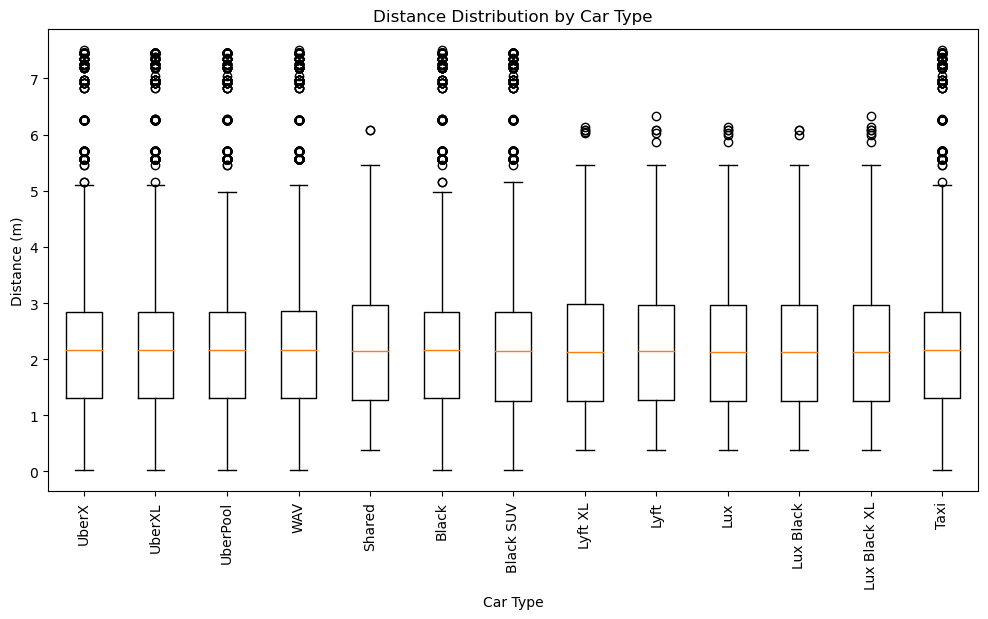

In [35]:

# 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2: Collect distances for each unique car type
car_type_distances = []
for car_type in unique_car_types:
    distances = final_df.loc[final_df['Ride_Type'] == car_type, 'Distance(m)']
    car_type_distances.append(distances)

# 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_distances, labels=unique_car_types)
plt.title('Distance Distribution by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Distance (m)')
plt.xticks(rotation=90)
plt.show()

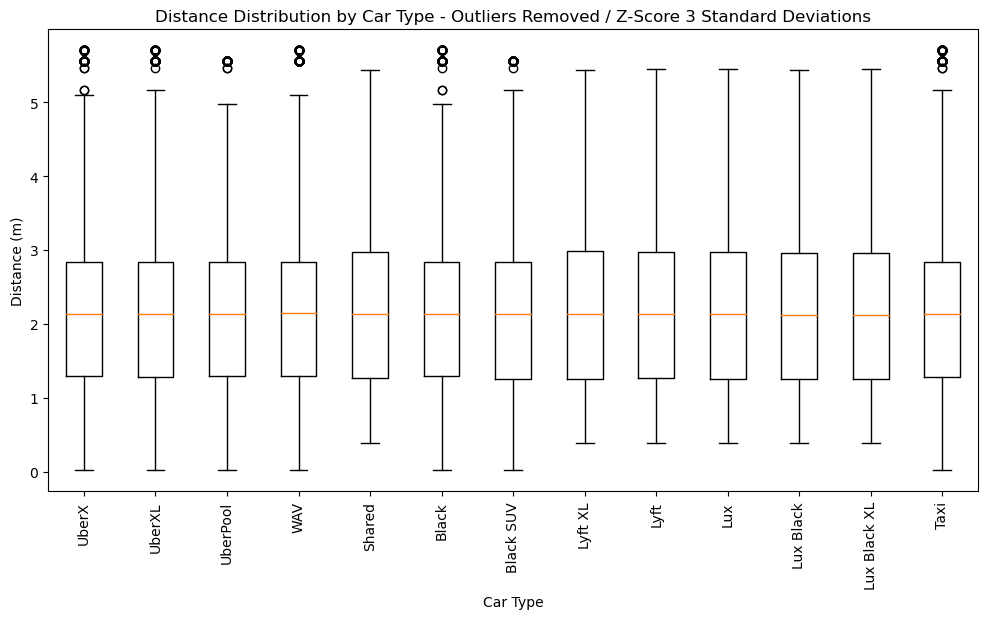

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Distance Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations
# 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# 2: Collect distances for each unique car type
car_type_distances = []
for car_type in unique_car_types:
    distances = final_df.loc[final_df['Ride_Type'] == car_type, 'Distance(m)']
    
    # Calculate Z-score for each distance
    z_scores = (distances - np.mean(distances)) / np.std(distances)
    
    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3
    
    # Remove outliers based on the Z-score method
    filtered_distances = distances[(z_scores <= threshold) & (z_scores >= -threshold)]
    
    # Store the filtered distances in the list
    car_type_distances.append(filtered_distances)

# 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_distances, labels=unique_car_types)
plt.title('Distance Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations')
plt.xlabel('Car Type')
plt.ylabel('Distance (m)')
plt.xticks(rotation=90)
plt.show()


ANALYSIS TO ABOVE PLOT: 'Distance Distribution by Car Type - Outliers Removed / Z-Score 3 Standard Deviations'

--------------------------------------------------------------

No discernible difference in CENTRAL TENDENCY in Distance Distribution by Car Type

##################################################################

In [37]:
from scipy import stats

# calculate: MEAN, MEDIAN, MODE, VARIANCE, STANDARD DEVIATION
# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Calculate the values for each ride type
results = {}
for car_type in unique_car_types:
    # Filter the dataframe by ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Calculate mean
    mean = np.mean(filtered_df['Price($)'])
    
    # Calculate median
    median = np.median(filtered_df['Price($)'])
    
    # Calculate mode
    mode = stats.mode(filtered_df['Price($)'])
    
    # Calculate variance
    variance = np.var(filtered_df['Price($)'])
    
    # Calculate standard deviation
    std_dev = np.std(filtered_df['Price($)'])
    
    # Store the results
    results[car_type] = {'Mean': mean, 'Median': median, 'Mode': mode.mode[0], 'Variance': variance, 'Standard Deviation': std_dev}

# Print the results
for car_type, stats in results.items():
    print(f"Ride Type: {car_type}")
    print(f"Mean: {stats['Mean']}")
    print(f"Median: {stats['Median']}")
    print(f"Mode: {stats['Mode']}")
    print(f"Variance: {stats['Variance']}")
    print(f"Standard Deviation: {stats['Standard Deviation']}")
    print()

/var/folders/6p/f3m54_816mjdktwyx_wxf48h0000gn/T/ipykernel_65170/1490952815.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(filtered_df['Price($)'])


Ride Type: UberX
Mean: 9.779783935180554
Median: 9.5
Mode: 9.5
Variance: 6.255946217195363
Standard Deviation: 2.5011889607135567

Ride Type: UberXL
Mean: 15.670520374313016
Median: 15.0
Mode: 15.0
Variance: 20.684172294442735
Standard Deviation: 4.547985520474173

Ride Type: UberPool
Mean: 8.735811250814006
Median: 8.5
Mode: 7.5
Variance: 4.417405627250317
Standard Deviation: 2.101762504958711

Ride Type: WAV
Mean: 9.788538538538539
Median: 9.5
Mode: 9.5
Variance: 6.327080847113403
Standard Deviation: 2.5153689286292384

Ride Type: Shared
Mean: 6.021713362068965
Median: 7.0
Mode: 7.0
Variance: 4.41555762473534
Standard Deviation: 2.101322827348368

Ride Type: Black
Mean: 20.516024844720498
Median: 19.5
Mode: 16.0
Variance: 24.825792893800696
Standard Deviation: 4.982548835064308

Ride Type: Black SUV
Mean: 30.229076532895718
Median: 28.5
Mode: 27.5
Variance: 23.338654779016686
Standard Deviation: 4.831009705953475

Ride Type: Lyft XL
Mean: 15.311472859901308
Median: 13.5
Mode: 16.5
Va

In [38]:
# MIKE - calculate MEAN, MEDIAN, MODE, VARIANCE, STANDARD DEVIATION --> & add 68-95-99.7 RULE , QUARTILES
from scipy import stats

# Unique car types
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Calculate the values for each ride type
results = {}
for car_type in unique_car_types:
    # Filter the dataframe by ride type
    filtered_df = final_df[final_df['Ride_Type'] == car_type]
    
    # Calculate mean
    mean = np.mean(filtered_df['Price($)'])
    
    # Calculate median
    median = np.median(filtered_df['Price($)'])
    
    # Calculate mode
    mode = stats.mode(filtered_df['Price($)'])
    
    # Calculate variance
    variance = np.var(filtered_df['Price($)'])
    
    # Calculate standard deviation
    std_dev = np.std(filtered_df['Price($)'])
    
    # Calculate 68-95-99.7 rule values
    lower_bound_68 = mean - std_dev
    upper_bound_68 = mean + std_dev
    
    lower_bound_95 = mean - 2 * std_dev
    upper_bound_95 = mean + 2 * std_dev
    
    lower_bound_99 = mean - 3 * std_dev
    upper_bound_99 = mean + 3 * std_dev
    
    # Calculate quartiles
    quartiles = filtered_df['Price($)'].quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    
    # Calculate Z-score
    z_scores = stats.zscore(filtered_df['Price($)'])
    
    # Store the results
    results[car_type] = {
        'Mean': mean,
        'Median': median,
        'Mode': mode.mode[0],
        'Variance': variance,
        'Standard Deviation': std_dev,
        'Lower Bound 68': lower_bound_68,
        'Upper Bound 68': upper_bound_68,
        'Lower Bound 95': lower_bound_95,
        'Upper Bound 95': upper_bound_95,
        'Lower Bound 99': lower_bound_99,
        'Upper Bound 99': upper_bound_99,
        'Lower Quartile': lowerq,
        'Upper Quartile': upperq,
        'IQR': iqr,
        'Z-Scores': z_scores
    }

# Print the results
for car_type, stats in results.items():
    print(f"Ride Type: {car_type}")
    print(f"Mean: {stats['Mean']}")
    print(f"Median: {stats['Median']}")
    print(f"Mode: {stats['Mode']}")
    print(f"Variance: {stats['Variance']}")
    print(f"Standard Deviation: {stats['Standard Deviation']}")
    print(f"Lower Quartile-25%: {stats['Lower Quartile']}")
    print(f"Upper Quartile-75%: {stats['Upper Quartile']}")
    print(f"IQR-Upper Quartile minus Lower Quartile: {stats['IQR']}")
    print(f"Lower Bound (68%): {stats['Lower Bound 68']}")
    print(f"Upper Bound (68%): {stats['Upper Bound 68']}")
    print(f"Lower Bound (95%): {stats['Lower Bound 95']}")
    print(f"Upper Bound (95%): {stats['Upper Bound 95']}")
    print(f"Lower Bound (99%): {stats['Lower Bound 99']}")
    print(f"Upper Bound (99%): {stats['Upper Bound 99']}")
    print("68-95-99.7 Rule:")
    print(f"Roughly 68% of the Data is between {stats['Lower Bound 68']} and {stats['Upper Bound 68']}")
    print(f"Roughly 95% of the Data is between {stats['Lower Bound 95']} and {stats['Upper Bound 95']}")
    print(f"Roughly 99.7% of the Data is between {stats['Lower Bound 99']} and {stats['Upper Bound 99']}")
    print()

/var/folders/6p/f3m54_816mjdktwyx_wxf48h0000gn/T/ipykernel_65170/3229737158.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(filtered_df['Price($)'])
/var/folders/6p/f3m54_816mjdktwyx_wxf48h0000gn/T/ipykernel_65170/3229737158.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

Ride Type: UberX
Mean: 9.779783935180554
Median: 9.5
Mode: 9.5
Variance: 6.255946217195363
Standard Deviation: 2.5011889607135567
Lower Quartile-25%: 8.0
Upper Quartile-75%: 10.5
IQR-Upper Quartile minus Lower Quartile: 2.5
Lower Bound (68%): 7.278594974466997
Upper Bound (68%): 12.28097289589411
Lower Bound (95%): 4.77740601375344
Upper Bound (95%): 14.782161856607667
Lower Bound (99%): 2.2762170530398835
Upper Bound (99%): 17.283350817321224
68-95-99.7 Rule:
Roughly 68% of the Data is between 7.278594974466997 and 12.28097289589411
Roughly 95% of the Data is between 4.77740601375344 and 14.782161856607667
Roughly 99.7% of the Data is between 2.2762170530398835 and 17.283350817321224

Ride Type: UberXL
Mean: 15.670520374313016
Median: 15.0
Mode: 15.0
Variance: 20.684172294442735
Standard Deviation: 4.547985520474173
Lower Quartile-25%: 12.5
Upper Quartile-75%: 17.5
IQR-Upper Quartile minus Lower Quartile: 5.0
Lower Bound (68%): 11.122534853838843
Upper Bound (68%): 20.21850589478719
L

/var/folders/6p/f3m54_816mjdktwyx_wxf48h0000gn/T/ipykernel_65170/3229737158.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(filtered_df['Price($)'])
/var/folders/6p/f3m54_816mjdktwyx_wxf48h0000gn/T/ipykernel_65170/3229737158.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

In [39]:
########### below added after 230720 4:15pm ##############

Ride_Type
Black           412885.00
Black SUV       607876.50
Lux             330299.00
Lux Black       424461.20
Lux Black XL    600229.50
Lyft            178235.35
Lyft XL         285467.10
Shared          111763.00
Taxi                 0.00
UberPool        174393.00
UberX           195537.00
UberXL          316497.50
WAV             195575.00
Name: Price($), dtype: float64


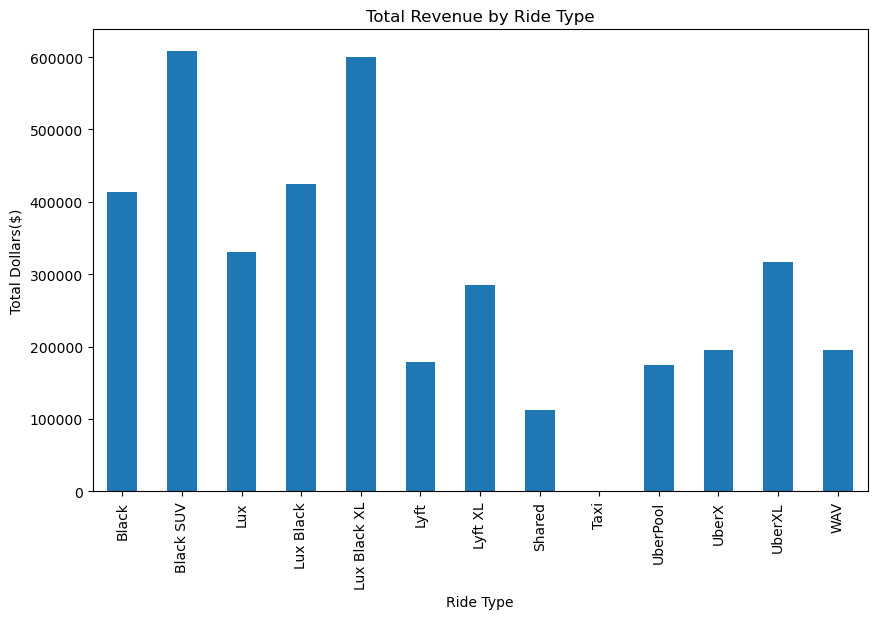

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded into "final_df"

# Calculate the sum total of prices for each ride type
sum_total_prices = final_df.groupby('Ride_Type')['Price($)'].sum()

# Print the list of sum totals
print(sum_total_prices)

# Create a bar graph
plt.figure(figsize=(10, 6))
sum_total_prices.plot(kind='bar')
plt.xlabel('Ride Type')
plt.ylabel('Total Dollars($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()


Here's the list of average revenue per ride for each ride type:

1- Black SUV: $30.18
2- Lux Black XL: $32.32
3- Lux Black: $22.99
4- Black: $20.52
5- Lux: $17.77
6- UberXL: $15.68
7- Lyft XL: $15.31
8- WAV: $9.80
9- UberX: $9.78
10- Lyft: $9.62
11- UberPool: $8.74
12- Shared: $6.02
13- Taxi: $0.00

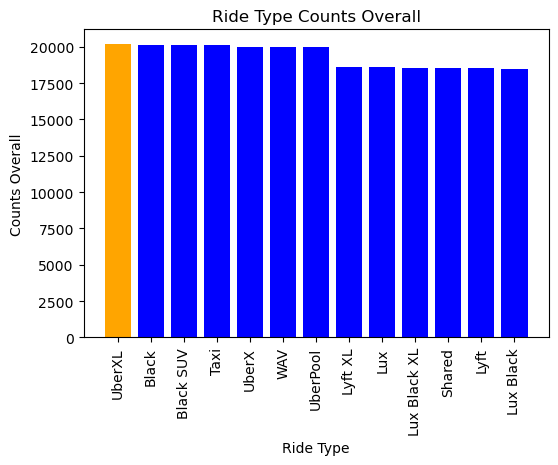

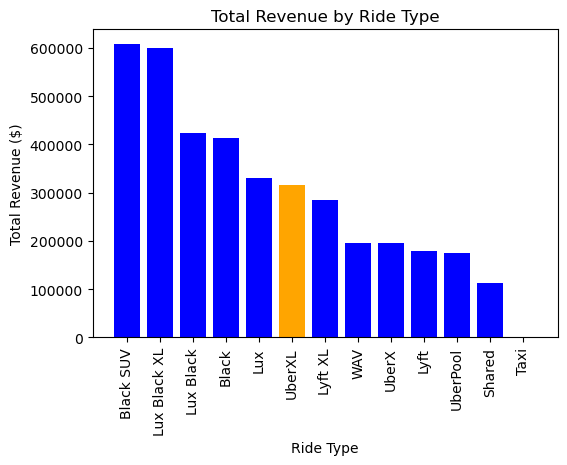

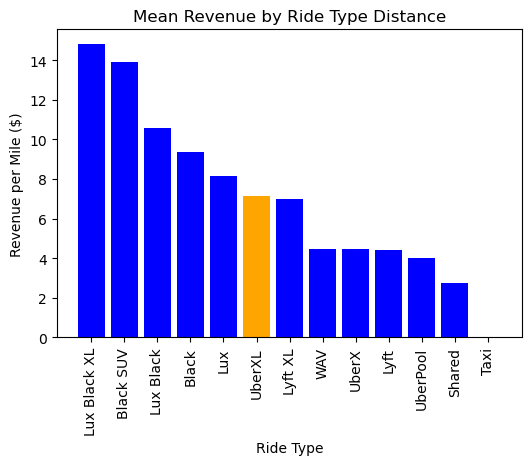

In [50]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberXL' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberXL' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberXL' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()


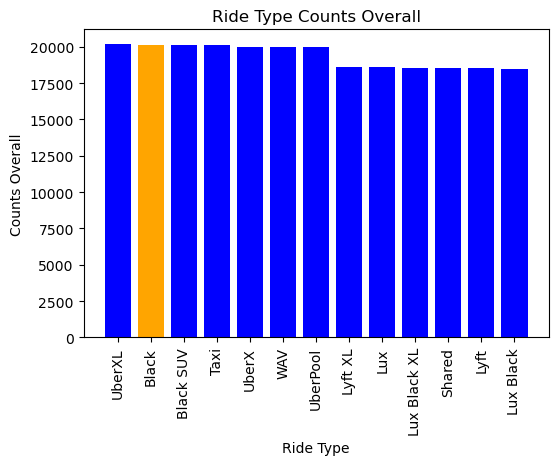

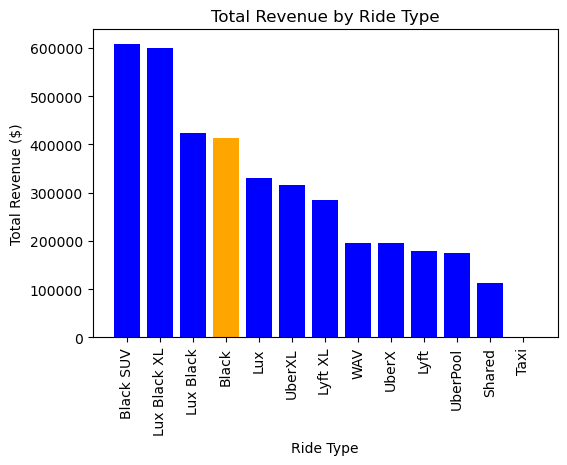

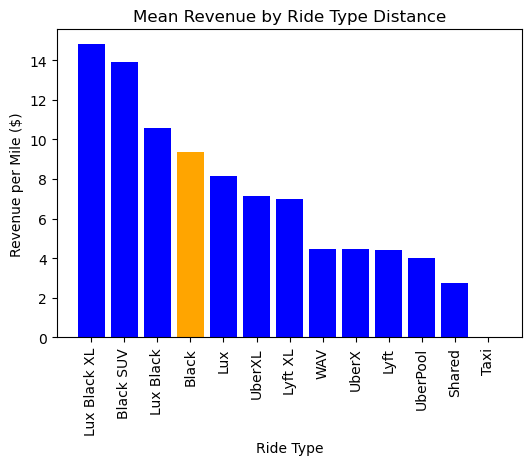

In [51]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

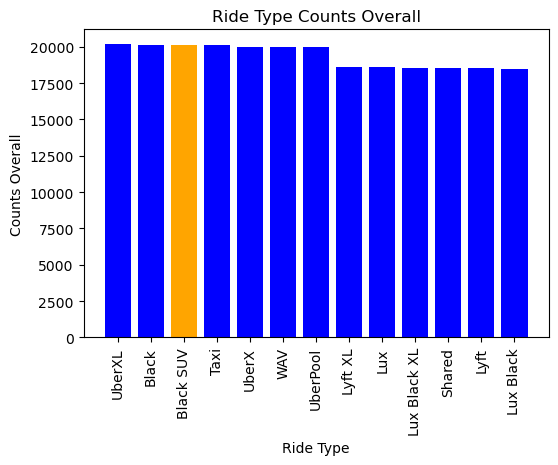

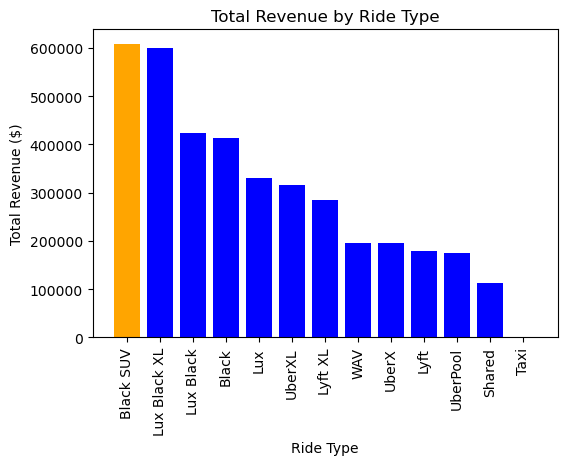

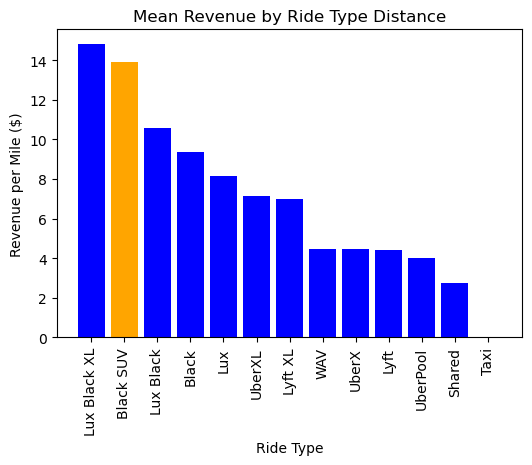

In [52]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black SUV' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black SUV' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Black SUV' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

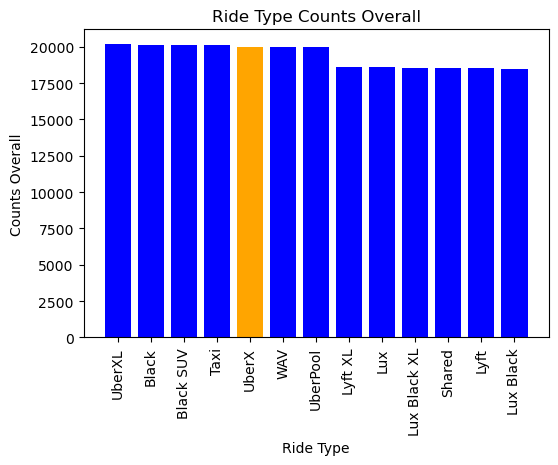

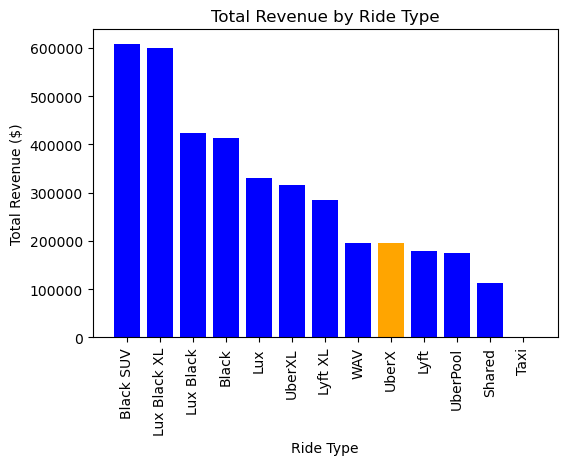

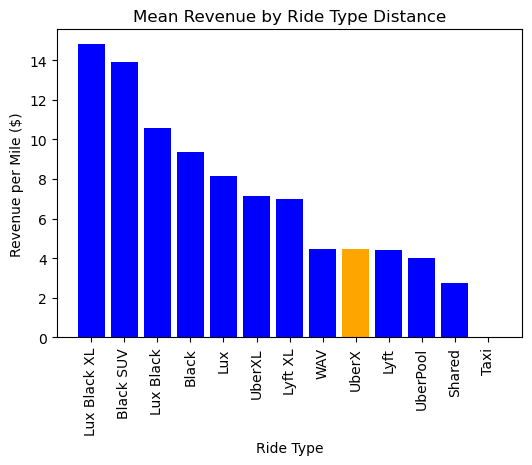

In [54]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberX' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberX' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberX' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

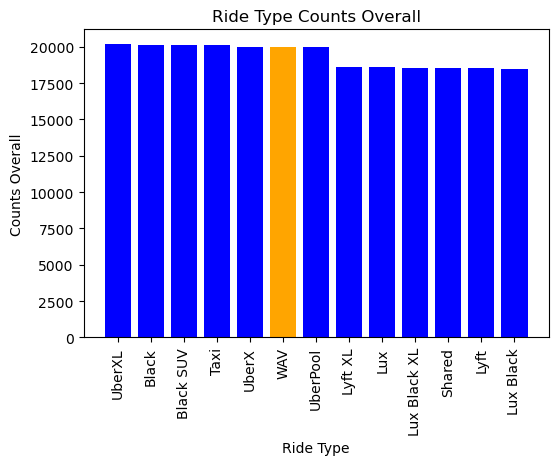

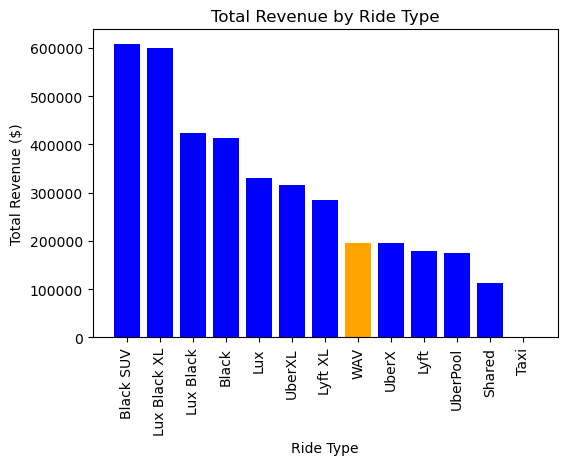

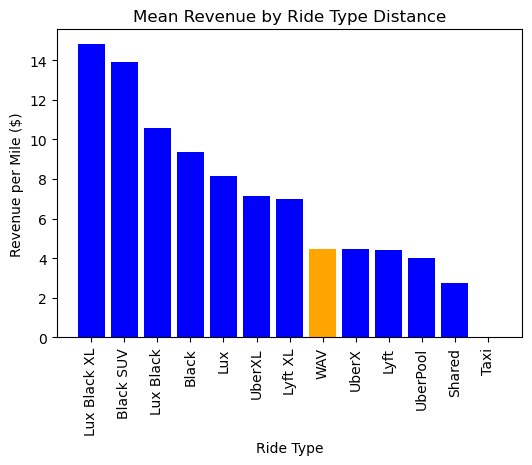

In [55]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'WAV' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'WAV' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'WAV' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

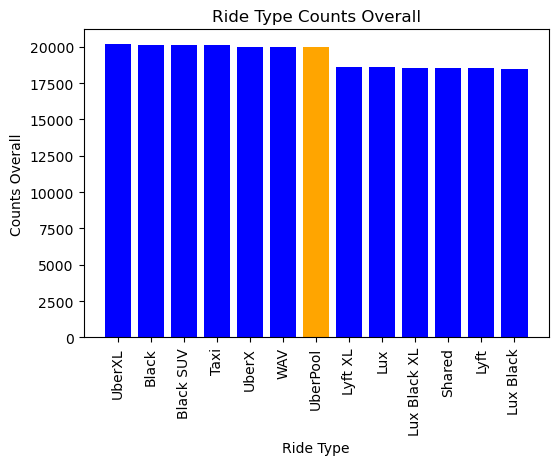

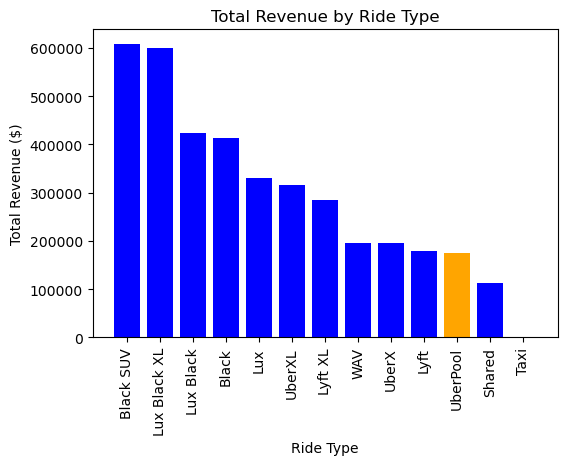

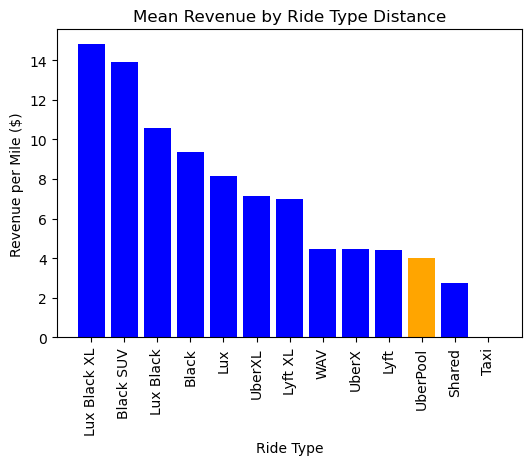

In [56]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberPool' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberPool' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'UberPool' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

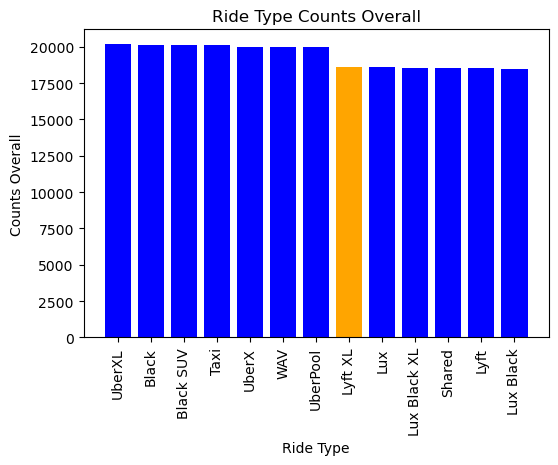

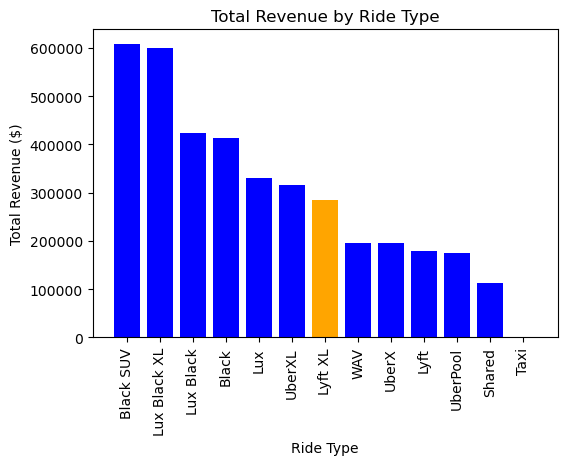

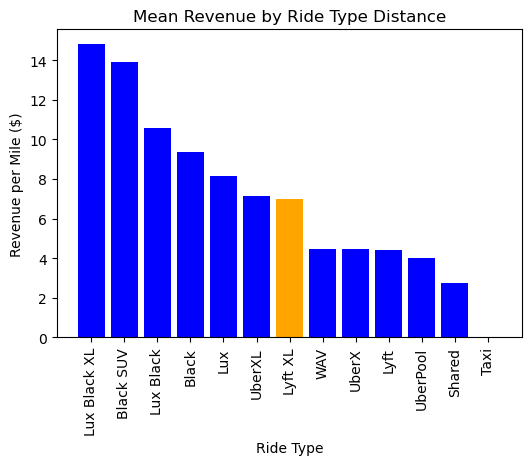

In [57]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft XL' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft XL' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft XL' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

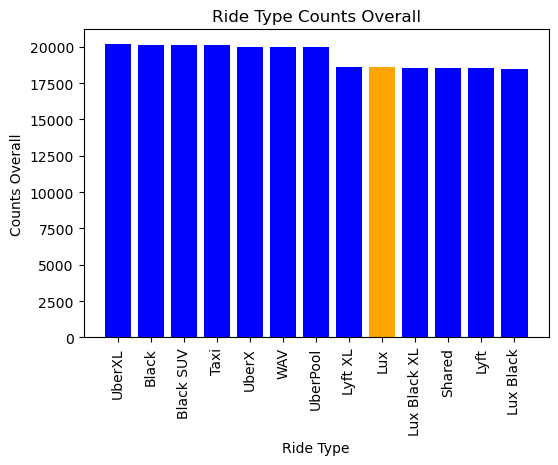

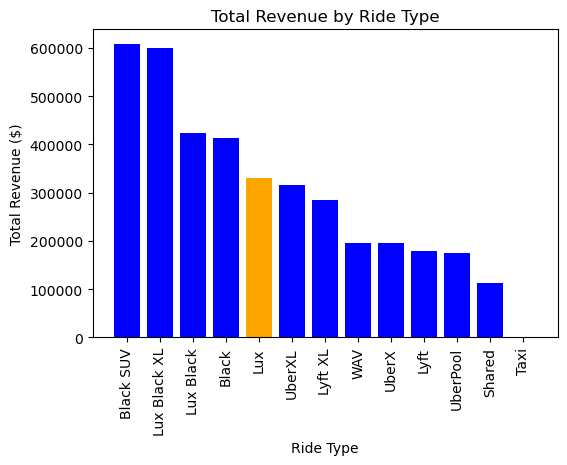

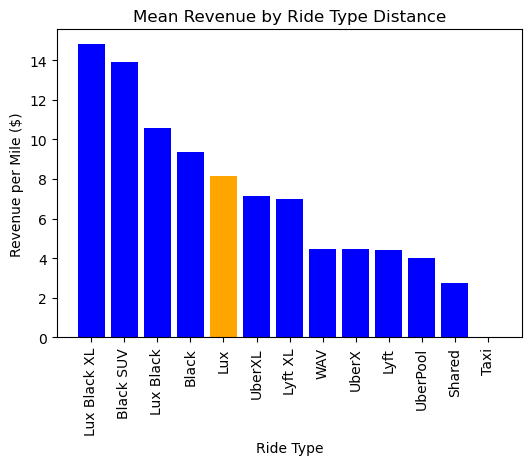

In [58]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

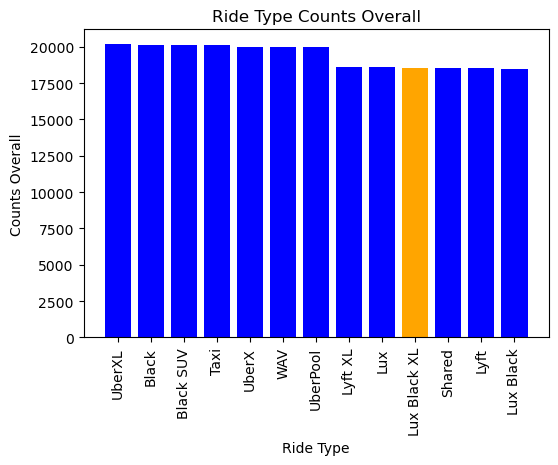

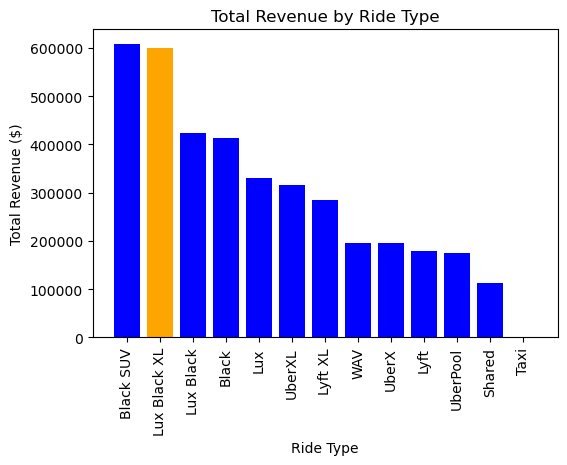

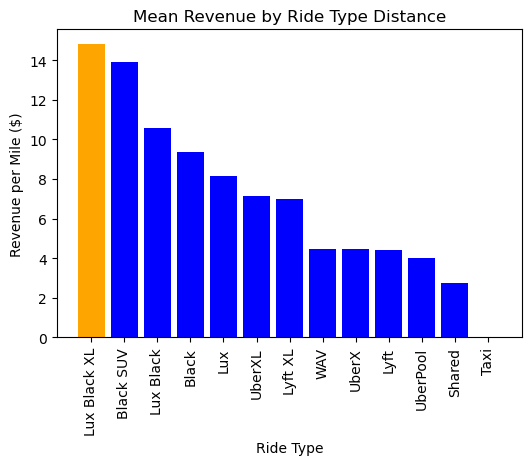

In [59]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux Black XL' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux Black XL' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lux Black XL' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

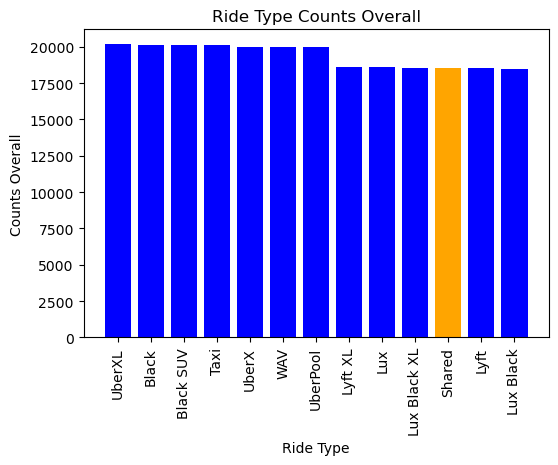

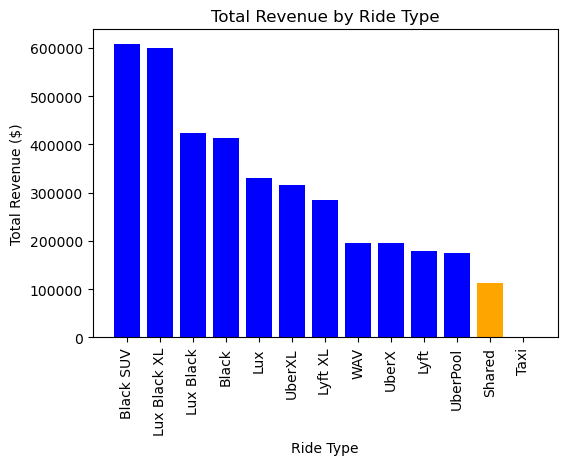

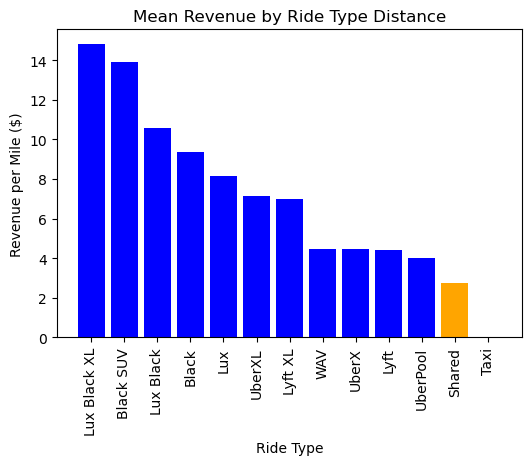

In [60]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Shared' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Shared' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Shared' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

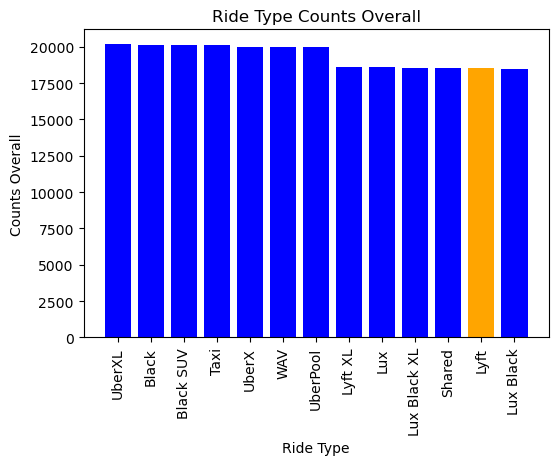

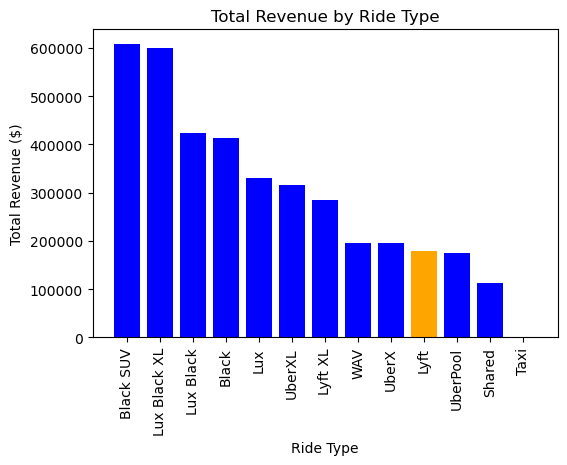

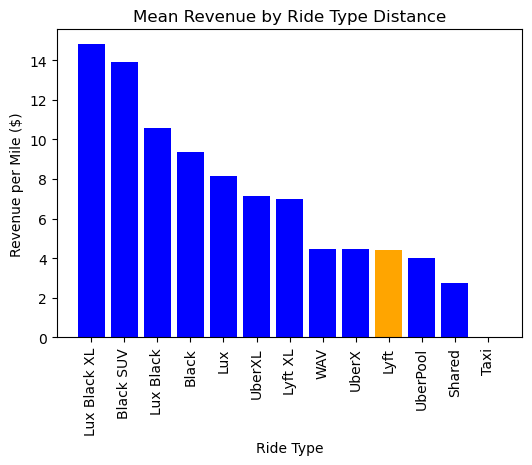

In [61]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['orange' if k == 'Lyft' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

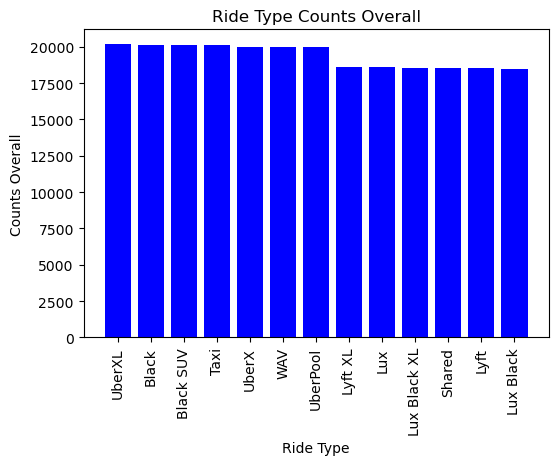

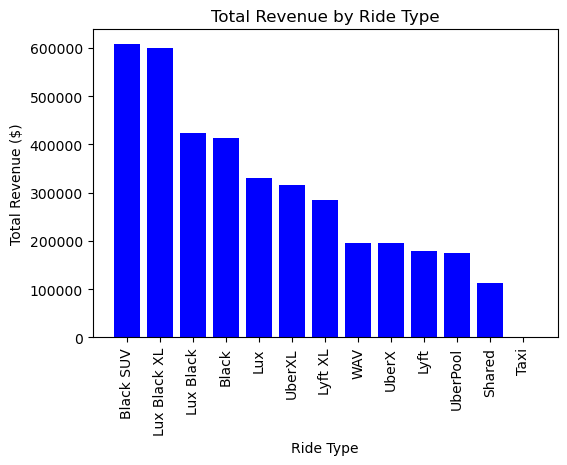

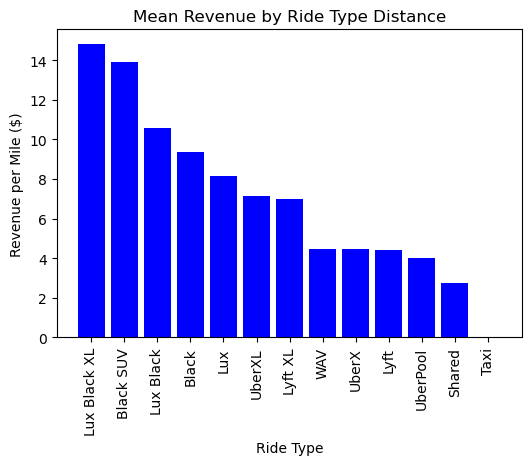

In [69]:
import matplotlib.pyplot as plt

# Ride type counts overall data
ride_type_counts = {
	"UberXL": 20197,
	"Black": 20125,
	"Black SUV": 20109,
	"Taxi": 20098,
	"UberX": 19994,
	"WAV": 19980,
	"UberPool": 19963,
	"Lyft XL": 18644,
	"Lux": 18586,
	"Lux Black XL": 18579,
	"Shared": 18560,
	"Lyft": 18534,
	"Lux Black": 18458
}

# Total revenue by ride type data
total_revenue = {
	"Black SUV": 607876.50,
	"Lux Black XL": 600229.50,
	"Lux Black": 424461.20,
	"Black": 412885.00,
	"Lux": 330299.00,
	"UberXL": 316497.50,
	"Lyft XL": 285467.10,
	"WAV": 195575.00,
	"UberX": 195537.00,
	"Lyft": 178235.35,
	"UberPool": 174393.00,
	"Shared": 111763.00,
	"Taxi": 0.00  # Updated value
}

# Mean revenue by ride type distance data
mean_revenue_by_distance = {
	"Lux Black XL": 14.82,
	"Black SUV": 13.89,
	"Lux Black": 10.57,
	"Black": 9.37,
	"Lux": 8.14,
	"UberXL": 7.16,
	"Lyft XL": 7.01,
	"WAV": 4.45,
	"UberX": 4.48,
	"Lyft": 4.40,
	"UberPool": 4.01,
	"Shared": 2.76,  # Updated value
	"Taxi": 0.00  # New ride type
}

# Create the first bar chart (Ride type counts overall)
plt.figure(figsize=(6, 4))
colors = ['blue' if k == 'Lyft' else 'blue' for k in ride_type_counts.keys()]
plt.bar(ride_type_counts.keys(), ride_type_counts.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Counts Overall')
plt.title('Ride Type Counts Overall')
plt.xticks(rotation=90)
plt.show()

# Create the second bar chart (Total revenue by ride type)
plt.figure(figsize=(6, 4))
colors = ['blue' if k == 'Lyft' else 'blue' for k in total_revenue.keys()]
plt.bar(total_revenue.keys(), total_revenue.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Ride Type')
plt.xticks(rotation=90)
plt.show()

# Create the third bar chart (Mean revenue by ride type distance)
plt.figure(figsize=(6, 4))
colors = ['blue' if k == 'Lyft' else 'blue' for k in mean_revenue_by_distance.keys()]
plt.bar(mean_revenue_by_distance.keys(), mean_revenue_by_distance.values(), color=colors)
plt.xlabel('Ride Type')
plt.ylabel('Revenue per Mile ($)')
plt.title('Mean Revenue by Ride Type Distance')
plt.xticks(rotation=90)
plt.show()

In [49]:
import pandas as pd

# Assuming your dataframe is already defined as 'final_df'

# Group the dataframe by 'Ride_Type' and calculate the sum of 'Distance(m)' for each unique ride type
ride_type_totals = final_df.groupby('Ride_Type')['Distance(m)'].sum()

# Convert the groupby result to a new dataframe for better visualization
result_df = pd.DataFrame(ride_type_totals).reset_index()

# Print the list of unique ride types and their respective total distances
print(result_df)


       Ride_Type  Distance(m)
0          Black     44099.90
1      Black SUV     43706.29
2            Lux     40549.24
3      Lux Black     40163.50
4   Lux Black XL     40521.30
5           Lyft     40534.25
6        Lyft XL     40709.59
7         Shared     40579.32
8           Taxi     43997.03
9       UberPool     43465.11
10         UberX     43697.21
11        UberXL     44203.65
12           WAV     43920.76


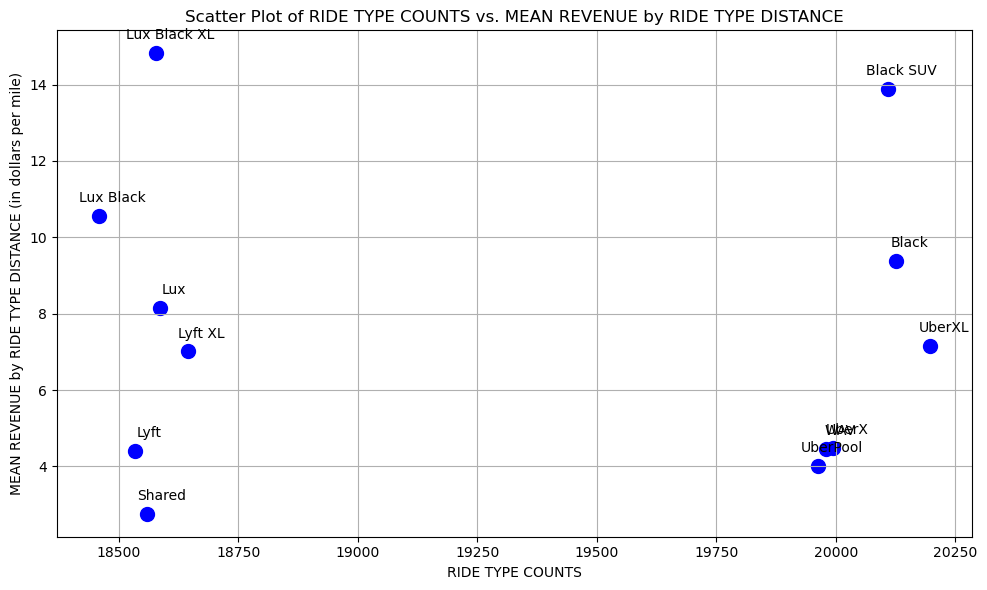

In [86]:
import matplotlib.pyplot as plt

# Data for RIDE TYPE COUNTS OVERALL
ride_type_counts = {
    'UberXL': 20197,
    'Black': 20125,
    'Black SUV': 20109,
    'UberX': 19994,
    'WAV': 19980,
    'UberPool': 19963,
    'Lyft XL': 18644,
    'Lux': 18586,
    'Lux Black XL': 18579,
    'Shared': 18560,
    'Lyft': 18534,
    'Lux Black': 18458
}

# Data for MEAN REVENUE by RIDE TYPE DISTANCE (in dollars per mile)
mean_revenue_by_ride_type_distance = {
    'Lux Black XL': 14.82,
    'Black SUV': 13.89,
    'Lux Black': 10.57,
    'Black': 9.37,
    'Lux': 8.14,
    'UberXL': 7.16,
    'Lyft XL': 7.01,
    'WAV': 4.45,
    'UberX': 4.48,
    'Lyft': 4.40,
    'UberPool': 4.01,
    'Shared': 2.76,
}

# Prepare the data for plotting
ride_types = list(ride_type_counts.keys())
ride_type_counts_list = list(ride_type_counts.values())
mean_revenue_list = [mean_revenue_by_ride_type_distance[ride_type] for ride_type in ride_types]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ride_type_counts_list, mean_revenue_list, marker='o', s=100, c='b')

# Label each corresponding ride type
for i, ride_type in enumerate(ride_types):
    plt.annotate(ride_type, (ride_type_counts_list[i], mean_revenue_list[i]),
                 textcoords="offset points", xytext=(10,10), ha='center')

# Add labels and title
plt.xlabel('RIDE TYPE COUNTS')
plt.ylabel('MEAN REVENUE by RIDE TYPE DISTANCE (in dollars per mile)')
plt.title('Scatter Plot of RIDE TYPE COUNTS vs. MEAN REVENUE by RIDE TYPE DISTANCE')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


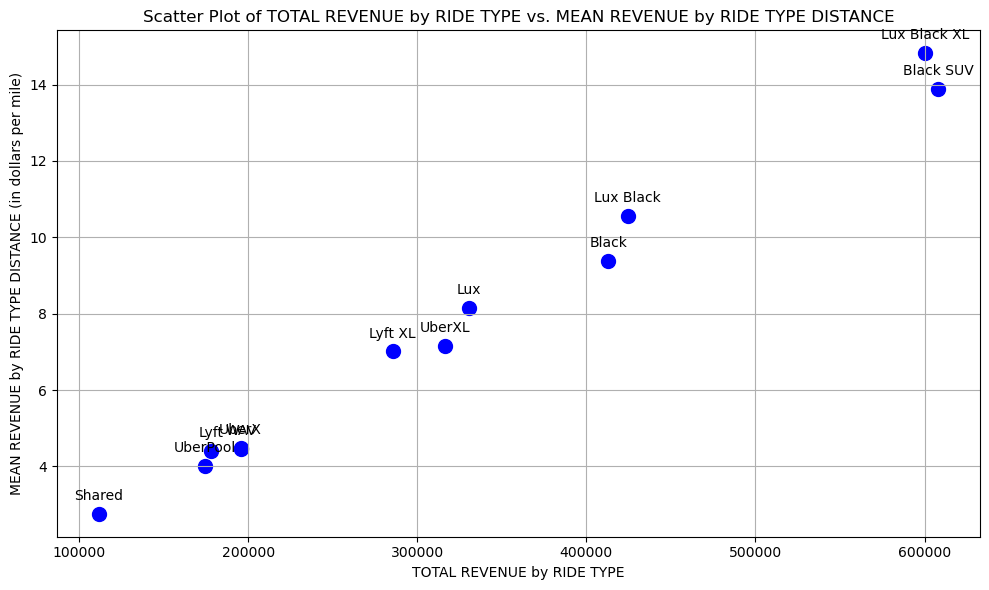

In [84]:
import matplotlib.pyplot as plt

# Data for TOTAL REVENUE by RIDE TYPE
total_revenue_by_ride_type = {
    'Black SUV': 607876.50,
    'Lux Black XL': 600229.50,
    'Lux Black': 424461.20,
    'Black': 412885.00,
    'Lux': 330299.00,
    'UberXL': 316497.50,
    'Lyft XL': 285467.10,
    'WAV': 195575.00,
    'UberX': 195537.00,
    'Lyft': 178235.35,
    'UberPool': 174393.00,
    'Shared': 111763.00,
}

# Data for MEAN REVENUE by RIDE TYPE DISTANCE (in dollars per mile)
mean_revenue_by_ride_type_distance = {
    'Lux Black XL': 14.82,
    'Black SUV': 13.89,
    'Lux Black': 10.57,
    'Black': 9.37,
    'Lux': 8.14,
    'UberXL': 7.16,
    'Lyft XL': 7.01,
    'WAV': 4.45,
    'UberX': 4.48,
    'Lyft': 4.40,
    'UberPool': 4.01,
    'Shared': 2.76,
}

# Prepare the data for plotting
ride_types = list(total_revenue_by_ride_type.keys())
total_revenue_list = list(total_revenue_by_ride_type.values())
mean_revenue_list = [mean_revenue_by_ride_type_distance[ride_type] for ride_type in ride_types]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(total_revenue_list, mean_revenue_list, marker='o', s=100, c='b')

# Label each corresponding ride type
for i, ride_type in enumerate(ride_types):
    plt.annotate(ride_type, (total_revenue_list[i], mean_revenue_list[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('TOTAL REVENUE by RIDE TYPE')
plt.ylabel('MEAN REVENUE by RIDE TYPE DISTANCE (in dollars per mile)')
plt.title('Scatter Plot of TOTAL REVENUE by RIDE TYPE vs. MEAN REVENUE by RIDE TYPE DISTANCE')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


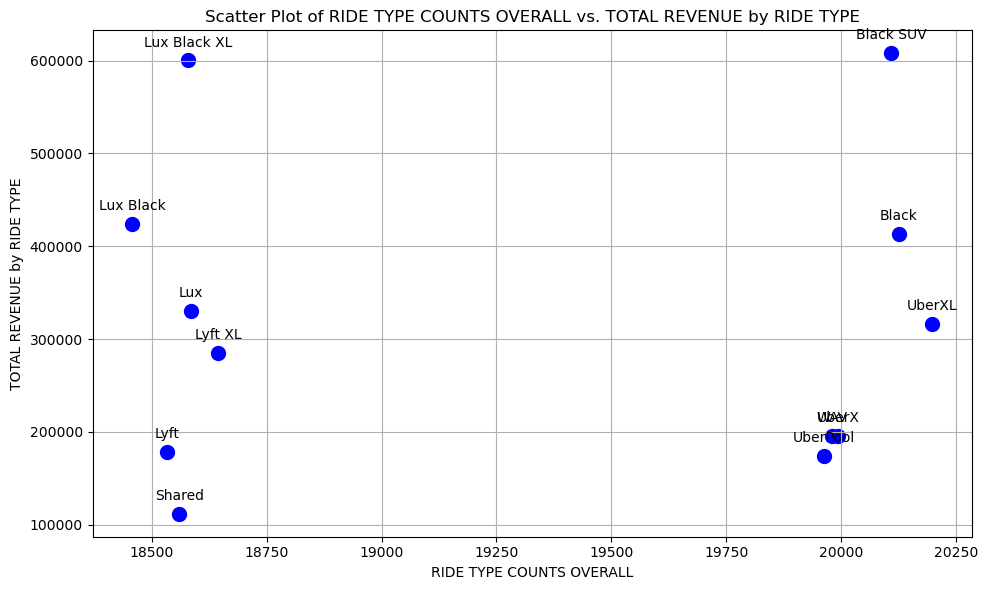

In [89]:
import matplotlib.pyplot as plt

# Data for TOTAL REVENUE by RIDE TYPE
total_revenue_by_ride_type = {
    'Black SUV': 607876.50,
    'Lux Black XL': 600229.50,
    'Lux Black': 424461.20,
    'Black': 412885.00,
    'Lux': 330299.00,
    'UberXL': 316497.50,
    'Lyft XL': 285467.10,
    'WAV': 195575.00,
    'UberX': 195537.00,
    'Lyft': 178235.35,
    'UberPool': 174393.00,
    'Shared': 111763.00
}

# Data for RIDE TYPE COUNTS OVERALL
ride_type_counts = {
    'UberXL': 20197,
    'Black': 20125,
    'Black SUV': 20109,
    'UberX': 19994,
    'WAV': 19980,
    'UberPool': 19963,
    'Lyft XL': 18644,
    'Lux': 18586,
    'Lux Black XL': 18579,
    'Shared': 18560,
    'Lyft': 18534,
    'Lux Black': 18458
}

# Prepare the data for plotting
ride_types = list(total_revenue_by_ride_type.keys())
total_revenue_list = list(total_revenue_by_ride_type.values())
ride_type_counts_list = [ride_type_counts[ride_type] for ride_type in ride_types]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ride_type_counts_list, total_revenue_list, marker='o', s=100, c='b')

# Label each corresponding ride type
for i, ride_type in enumerate(ride_types):
    plt.annotate(ride_type, (ride_type_counts_list[i], total_revenue_list[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('RIDE TYPE COUNTS OVERALL')
plt.ylabel('TOTAL REVENUE by RIDE TYPE')
plt.title('Scatter Plot of RIDE TYPE COUNTS OVERALL vs. TOTAL REVENUE by RIDE TYPE')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
